In [84]:
import os
import json
import hashlib
from pathlib import Path
import __main__

try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

try:
    from scipy.stats import ks_2samp
except ImportError as e:
    raise ImportError("Q2 requires SciPy. Install with: pip install scipy") from e


repo_root = Path.cwd()

gan_scripts_dir = Path(os.environ.get("GAN_SCRIPTS_DIR", str(repo_root))).resolve()

training_script_path = gan_scripts_dir / "LOB_GAN_training.py"
testing_script_path  = gan_scripts_dir / "LOB_GAN_testing.py"

# .env
if "LOB_GAN_DATA_DIR" not in os.environ:
    raise EnvironmentError(
        "Missing LOB_GAN_DATA_DIR. Create a .env with:\n"
        "LOB_GAN_DATA_DIR=YOUR_PATH_TO_assignment4_datafiles"
    )
stock_data_dir = Path(os.environ["LOB_GAN_DATA_DIR"]).resolve()

# Outputs/caches
q1_output_root = (repo_root / "q1_notebook_outputs").resolve()
q2_output_root = (repo_root / "q2_notebook_outputs").resolve()
cache_root     = (repo_root / "cache").resolve()

q1_output_root.mkdir(parents=True, exist_ok=True)
q2_output_root.mkdir(parents=True, exist_ok=True)
cache_root.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Repo root:", repo_root)
print("Scripts dir:", gan_scripts_dir)
print("Data dir:", stock_data_dir)
print("Device:", device)





Repo root: c:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4
Scripts dir: C:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4
Data dir: C:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4\assignment4_datafiles
Device: cpu


In [85]:
def _stable_json_hash(payload: dict) -> str:
    encoded = json.dumps(payload, sort_keys=True, separators=(",", ":")).encode("utf-8")
    return hashlib.sha256(encoded).hexdigest()[:16]


def _write_json(path: Path, payload: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(payload, indent=2, sort_keys=True), encoding="utf-8")


def _read_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding="utf-8"))


def _config_matches(cache_config_path: Path, expected_config: dict) -> bool:
    if not cache_config_path.exists():
        return False
    saved = _read_json(cache_config_path)
    return saved.get("config_hash") == expected_config.get("config_hash")


def _ensure_script_env_ready(script_path: Path, required_env_markers: list[str]) -> None:
    """
    Ensures the provided scripts were minimally adapted to read env vars.
    """
    text = script_path.read_text(encoding="utf-8", errors="ignore")
    missing = [m for m in required_env_markers if m not in text]
    if missing:
        raise RuntimeError(
            f"{script_path.name} does not appear to support env configuration.\n"
            f"Missing markers: {missing}\n\n"
            "Fix: inside if __name__=='__main__': read stockDataDir/stock/LRs from os.environ.\n"
            "If you already did this, ensure the literal strings appear in the file."
        )


In [86]:
import subprocess
import sys

def run_python_script(script_path, working_dir, env_overrides):
    env = os.environ.copy()
    env.update(env_overrides)
    env.setdefault("MPLBACKEND", "Agg")

    completed = subprocess.run(
        [sys.executable, str(script_path)],
        cwd=str(working_dir),
        env=env,
        capture_output=True,
        text=True,
    )

    if completed.returncode != 0:
        print("\n SUBPROCESS STDOUT\n", completed.stdout)
        print("\n SUBPROCESS STDERR\n", completed.stderr)
        raise RuntimeError(
            f"Script failed: {script_path.name} (exit={completed.returncode}). "
            f"See stdout/stderr above."
        )

    
    if completed.stdout.strip():
        print(completed.stdout)



def q1_artifacts_present(ticker_dir: Path, ticker: str) -> bool:
    """Check for the minimal set of outputs in cache"""
    needed = [
        ticker_dir / f"{ticker}_generator1.pth",
        ticker_dir / f"{ticker}_discriminator1.pth",
        ticker_dir / f"{ticker}_train_g_d.csv",
        ticker_dir / f"{ticker}_eval_g_d.csv",
    ]
    return all(p.exists() for p in needed)


def q1_plot_present(ticker_dir: Path, ticker: str) -> bool:
    """Loss plot"""
    return (ticker_dir / f"{ticker}_q1_loss_curves.png").exists()


def q1_test_marker_present(ticker_dir: Path, ticker: str) -> bool:
    """Marker file indicating the testing script ran successfully."""
    return (ticker_dir / f"{ticker}__testing_ok.marker").exists()


def q1_make_run_config(
    ticker: str,
    train_months: list[str],
    lr_g: float,
    lr_d: float,
    batch_size: int,
    epochs: int,
    seed: int,
) -> dict:
    cfg = {
        "ticker": ticker,
        "train_months": train_months,
        "lr_g": lr_g,
        "lr_d": lr_d,
        "batch_size": batch_size,
        "epochs": epochs,
        "seed": seed,
        "data_dir": str(stock_data_dir),
        "training_script": str(training_script_path),
        "testing_script": str(testing_script_path),
    }
    cfg["config_hash"] = _stable_json_hash(cfg)
    return cfg


def q1_plot_losses_from_csv(ticker_dir: Path, ticker: str, smooth_window: int = 25) -> None:
    """
    Plot training/validation loss curves from the CSVs written by the training script.
    """
    train_csv = ticker_dir / f"{ticker}_train_g_d.csv"
    eval_csv  = ticker_dir / f"{ticker}_eval_g_d.csv"

    train_df = pd.read_csv(train_csv, index_col=0)
    eval_df  = pd.read_csv(eval_csv, index_col=0)

    def _row(df: pd.DataFrame, name: str) -> np.ndarray:
        s = df.loc[name].dropna().to_numpy(dtype=float)
        if smooth_window > 1:
            s = pd.Series(s).rolling(smooth_window, min_periods=1).mean().to_numpy()
        return s

    train_g = _row(train_df, "train_g")
    train_d = _row(train_df, "train_d")
    eval_g  = _row(eval_df, "eval_g")
    eval_d  = _row(eval_df, "eval_d")

    fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=False)

    axes[0].plot(train_g, label="G train")
    axes[0].plot(eval_g,  label="G validation")
    axes[0].set_title(f"{ticker} — Generator loss (smoothed window={smooth_window})")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.25)
    axes[0].legend()

    axes[1].plot(train_d, label="D train")
    axes[1].plot(eval_d,  label="D validation")
    axes[1].set_title(f"{ticker} — Discriminator loss")
    axes[1].set_xlabel("Update step (mini-batch)")
    axes[1].set_ylabel("Loss")
    axes[1].grid(True, alpha=0.25)
    axes[1].legend()

    plt.tight_layout()
    out_path = ticker_dir / f"{ticker}_q1_loss_curves.png"
    plt.savefig(out_path, dpi=160)
    plt.show()
    print(f" Saved: {out_path}")


In [87]:
q1_tickers = ["0050", "0056", "2330"]
q1_train_months = ["202310", "202311", "202312"]

# tuning
q1_hyperparams = {
    "0050": {"lr_g": 0.00375, "lr_d": 0.00100},
    "0056": {"lr_g": 0.00375, "lr_d": 0.00100},
    "2330": {"lr_g": 0.00300, "lr_d": 0.00100},
}
q1_batch_size = int(os.environ.get("LOB_GAN_BATCH_SIZE", "50"))
q1_epochs     = int(os.environ.get("LOB_GAN_EPOCHS", "200"))
q1_seed       = int(os.environ.get("LOB_GAN_SEED", "307"))

# Ensuring scripts are env-ready
required_markers = ["LOB_GAN_DATA_DIR", "LOB_GAN_STOCK"]
_ensure_script_env_ready(training_script_path, required_markers)
_ensure_script_env_ready(testing_script_path, required_markers)

for ticker in q1_tickers:
    ticker_dir = q1_output_root / ticker
    ticker_dir.mkdir(parents=True, exist_ok=True)

    lr_g = float(q1_hyperparams[ticker]["lr_g"])
    lr_d = float(q1_hyperparams[ticker]["lr_d"])

    run_cfg = q1_make_run_config(
        ticker=ticker,
        train_months=q1_train_months,
        lr_g=lr_g,
        lr_d=lr_d,
        batch_size=q1_batch_size,
        epochs=q1_epochs,
        seed=q1_seed,
    )
    cfg_path = ticker_dir / "q1_run_config.json"

    if q1_artifacts_present(ticker_dir, ticker) and _config_matches(cfg_path, run_cfg):
        print(f"{ticker}: cached training found skipping training")
    else:
        print(f"{ticker}: training not cached or config changed running training")

        env = {
            "LOB_GAN_DATA_DIR": str(stock_data_dir),
            "LOB_GAN_STOCK": ticker,
            "LOB_GAN_SEED": str(q1_seed),

            "KMP_DUPLICATE_LIB_OK": "TRUE",

            "OMP_NUM_THREADS": "1",
            "MKL_NUM_THREADS": "1",

            "LOB_GAN_SKIP_PLOTS": "1",
        }

        run_python_script(training_script_path, ticker_dir, env)
        _write_json(cfg_path, run_cfg)

    if q1_plot_present(ticker_dir, ticker) and _config_matches(cfg_path, run_cfg):
        print(f"{ticker}: cached loss plot found skipping plot.")
    else:
        q1_plot_losses_from_csv(ticker_dir, ticker, smooth_window=25)

    # testing both files
    if q1_test_marker_present(ticker_dir, ticker) and _config_matches(cfg_path, run_cfg):
        print(f"{ticker}: cached testing run found skipping testing")
    else:
        print(f"{ticker}: running testing ")

        env = {
            "LOB_GAN_DATA_DIR": str(stock_data_dir),
            "LOB_GAN_STOCK": ticker,
            "LOB_GAN_SEED": str(q1_seed),
        }
        run_python_script(testing_script_path, ticker_dir, env)

        (ticker_dir / f"{ticker}__testing_ok.marker").write_text("ok", encoding="utf-8")

print("\n[Q1] Done.")


0050: cached training found skipping training
0050: cached loss plot found skipping plot.
0050: cached testing run found skipping testing
0056: cached training found skipping training
0056: cached loss plot found skipping plot.
0056: cached testing run found skipping testing
2330: cached training found skipping training
2330: cached loss plot found skipping plot.
2330: cached testing run found skipping testing

[Q1] Done.


In [88]:
if str(gan_scripts_dir) not in sys.path:
    sys.path.insert(0, str(gan_scripts_dir))

import importlib

lob_ref = importlib.import_module("LOB_GAN_training")
prepare_minutely_data = lob_ref.prepareMinutelyData


In [89]:
LOB_COLS = [
    "date","time","lastPx","size","volume",
    "SP1","BP1","SV1","BV1",
    "SP2","BP2","SV2","BV2",
    "SP3","BP3","SV3","BV3",
    "SP4","BP4","SV4","BV4",
    "SP5","BP5","SV5","BV5",
]


def q2_cache_paths(ticker: str, months: list[str], threshold: float, version: str = "v1") -> dict:
    """
    Centralized file paths for Q2 caches.
    Bump 'version' if you change feature definitions.
    """
    tag = f"{version}__{ticker}__{'-'.join(months)}__thr{threshold:.3f}"
    base = cache_root / "q2" / ticker
    base.mkdir(parents=True, exist_ok=True)
    return {
        "cfg": base / f"q2_config__{tag}.json",
        "minutely_pkl": base / f"minutely__{tag}.pkl",
        "X_npz": base / f"ganX__{tag}.npz",
        "day_scores_csv": base / f"day_scores__{tag}.csv",
        "features_pkl": base / f"features__{tag}.pkl",
        "results_csv": base / f"results__{tag}.csv",
    }


def q2_make_run_config(ticker: str, months: list[str], threshold: float) -> dict:
    cfg = {
        "ticker": ticker,
        "months": months,
        "threshold": float(threshold),
        "data_dir": str(stock_data_dir),
        "discriminator_path": str((q1_output_root / ticker / f"{ticker}_discriminator1.pth").resolve()),
        "feature_version": "v1",
    }
    cfg["config_hash"] = _stable_json_hash(cfg)
    return cfg


def q2_load_raw_months(ticker: str, months: list[str]) -> pd.DataFrame:
    parts = []
    for m in months:
        fp = stock_data_dir / f"{ticker}_md_{m}_{m}.csv.gz"
        if not fp.exists():
            print(f"[WARN] Missing file: {fp.name} (skipping)")
            continue
        parts.append(pd.read_csv(fp, compression="gzip", usecols=LOB_COLS))
        print(f"Loaded {fp.name}")
    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()


In [90]:
def q2_load_or_build_minutely(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["minutely_pkl"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_pickle(paths["minutely_pkl"])

    raw_df = q2_load_raw_months(ticker, months)
    if raw_df.empty:
        raise FileNotFoundError(f"No raw test data loaded for {ticker} months={months}")

    trading_days_present = sorted(raw_df["date"].astype(str).unique().tolist())
    minutely_df = prepare_minutely_data(raw_df, trading_days_present)
    if minutely_df is None or minutely_df.empty:
        raise ValueError(f"prepareMinutelyData produced empty minutely df for {ticker}")

    minutely_df.to_pickle(paths["minutely_pkl"])
    _write_json(paths["cfg"], cfg)
    return minutely_df


def q2_build_gan_X_and_dates(minutely_df: pd.DataFrame) -> tuple[np.ndarray, list[str]]:
    """Same shaping/normalization as provided scripts: daily 265-min sequences -> X (N,265,20)."""
    daily_arrays = []
    daily_dates = []

    for date_key, day_df in minutely_df.groupby("date", sort=True):
        if day_df.shape[0] == 265:
            daily_arrays.append(day_df.values)
            daily_dates.append(str(date_key))

    projdata = np.array(daily_arrays)
    if projdata.size == 0:
        raise ValueError("No full 265-minute days found in testing data.")

    X = projdata[:, :, 5:].astype(float)
    X[:, :, -10:] = np.log(1.0 + X[:, :, -10:])

    mu = X.mean(axis=1)
    sig = X.std(axis=1)
    X = np.transpose((np.transpose(X, (1, 0, 2)) - mu) / (2.0 * sig), (1, 0, 2))
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X, daily_dates


def q2_load_or_build_ganX(ticker: str, months: list[str], threshold: float) -> tuple[np.ndarray, list[str]]:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["X_npz"].exists() and _config_matches(paths["cfg"], cfg):
        blob = np.load(paths["X_npz"], allow_pickle=True)
        return blob["X"], blob["daily_dates"].tolist()

    minutely_df = q2_load_or_build_minutely(ticker, months, threshold)
    X, dates = q2_build_gan_X_and_dates(minutely_df)

    np.savez_compressed(paths["X_npz"], X=X, daily_dates=np.array(dates, dtype=object))
    _write_json(paths["cfg"], cfg)
    return X, dates


In [91]:
def q2_load_discriminator(ticker: str) -> torch.nn.Module:
    """
    Robust discriminator loader.

    Why needed:
    - Your Q1 training saved the whole model object (`torch.save(model, ...)`) while the training
      script was running as __main__. That pickles the class as __main__.Discriminator.
    - In a notebook, __main__ is different, so torch.load can't find the class.

    Strategy:
    1) Prefer loading a saved state_dict (portable across notebooks/scripts).
    2) If state_dict doesn't exist yet, load the old pickled model by injecting class symbols into __main__,
       then immediately write a state_dict file for future runs.
    """
    model_path = q1_output_root / ticker / f"{ticker}_discriminator1.pth"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing discriminator model: {model_path}")

    # Portable cache (created automatically the first time)
    state_path = q1_output_root / ticker / f"{ticker}_discriminator1_state_dict.pth"

    # Always ensure the class is available for unpickling if needed
    # (lob_ref is your imported LOB_GAN_training module that defines Discriminator)
    __main__.Discriminator = lob_ref.Discriminator
    __main__.Generator = lob_ref.Generator  # harmless; helps if generator is ever loaded similarly

    # 1) If we already have a portable state_dict, use it
    if state_path.exists():
        disc = lob_ref.Discriminator()
        sd = torch.load(state_path, map_location="cpu")
        disc.load_state_dict(sd)
        disc.to(device).eval()
        return disc

    # 2) Otherwise, load the pickled full model (requires the __main__ injection above)
    try:
        loaded = torch.load(model_path, map_location="cpu", weights_only=False)
    except TypeError:
        loaded = torch.load(model_path, map_location="cpu")

    loaded.eval()

    # Save a portable state_dict for next time (CPU tensors)
    torch.save(loaded.state_dict(), state_path)

    # Return model on correct device
    loaded.to(device).eval()
    print(f"[Q2] Converted and cached state_dict for {ticker}: {state_path}")
    return loaded




@torch.no_grad()
def q2_score_days(discriminator: torch.nn.Module, X: np.ndarray, batch_size: int = 64) -> np.ndarray:
    discriminator = discriminator.to(device)
    scores = []
    n = X.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = torch.tensor(X[start:end], dtype=torch.float32, device=device)
        out = discriminator(batch).detach().cpu().numpy().reshape(-1)
        scores.append(out)
    return np.concatenate(scores, axis=0)


def q2_load_or_build_day_scores(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["day_scores_csv"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_csv(paths["day_scores_csv"])

    X, dates = q2_load_or_build_ganX(ticker, months, threshold)
    disc = q2_load_discriminator(ticker)

    scores = q2_score_days(disc, X, batch_size=64)
    out = pd.DataFrame({
        "date": dates,
        "discriminator_score": scores,
        "is_abnormal": scores <= threshold,
    })

    out.to_csv(paths["day_scores_csv"], index=False)
    _write_json(paths["cfg"], cfg)
    return out


In [92]:
def q2_compute_features(minutely_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute Q2 microstructure variables (per minutely snapshot), with within-day returns/diffs.
    """
    df = minutely_df.copy().sort_index()

    df["date_str"] = df["date"].astype(str)

    df["lastPx"] = pd.to_numeric(df["lastPx"], errors="coerce")
    df["BP1"] = pd.to_numeric(df["BP1"], errors="coerce")
    df["SP1"] = pd.to_numeric(df["SP1"], errors="coerce")
    df["size"] = pd.to_numeric(df["size"], errors="coerce")

    for k in ["BV1","SV1","BV2","SV2","BV3","SV3","BV4","SV4","BV5","SV5"]:
        df[k] = pd.to_numeric(df[k], errors="coerce")

    # Midquote + spread
    df["midquote"] = (df["BP1"] + df["SP1"]) / 2.0
    df["spread"] = df["SP1"] - df["BP1"]

    # Returns/diffs within day
    df["trade_price_return"] = df.groupby("date_str")["lastPx"].pct_change()
    df["midquote_return"] = df.groupby("date_str")["midquote"].pct_change()
    df["spread_diff_1"] = df.groupby("date_str")["spread"].diff()

    # Trade size
    df["trade_size"] = df["size"]

    # Pressure 1-level
    denom1 = df["BV1"] + df["SV1"]
    df["pressure_1"] = np.where(denom1 != 0, (df["BV1"] - df["SV1"]) / denom1, np.nan)

    # Pressure 5-level
    bv_sum = df[["BV1","BV2","BV3","BV4","BV5"]].sum(axis=1)
    sv_sum = df[["SV1","SV2","SV3","SV4","SV5"]].sum(axis=1)
    denom5 = bv_sum + sv_sum
    df["pressure_5"] = np.where(denom5 != 0, (bv_sum - sv_sum) / denom5, np.nan)

    features = df[
        ["date_str", "time",
         "trade_price_return", "midquote_return",
         "trade_size",
         "spread", "spread_diff_1",
         "pressure_1", "pressure_5"]
    ].replace([np.inf, -np.inf], np.nan)

    return features



def q2_load_or_build_features(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["features_pkl"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_pickle(paths["features_pkl"])

    minutely_df = q2_load_or_build_minutely(ticker, months, threshold)
    features = q2_compute_features(minutely_df)

    features.to_pickle(paths["features_pkl"])
    _write_json(paths["cfg"], cfg)
    return features


In [93]:
def q2_moments(series: pd.Series) -> dict:
    """
    mean/variance/skew/kurtosis
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return {"n": 0, "mean": np.nan, "var": np.nan, "skew": np.nan, "kurt_excess": np.nan}
    return {
        "n": int(s.shape[0]),
        "mean": float(s.mean()),
        "var": float(s.var(ddof=1)),
        "skew": float(s.skew()),
        "kurt_excess": float(s.kurt()),
    }


def q2_ks(a: pd.Series, b: pd.Series) -> dict:
    a = pd.to_numeric(a, errors="coerce").dropna().to_numpy(dtype=float)
    b = pd.to_numeric(b, errors="coerce").dropna().to_numpy(dtype=float)
    if a.size < 2 or b.size < 2:
        return {"ks_stat": np.nan, "ks_pvalue": np.nan}
    res = ks_2samp(a, b, alternative="two-sided", mode="auto")
    return {"ks_stat": float(res.statistic), "ks_pvalue": float(res.pvalue)}


def q2_load_or_build_results(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["results_csv"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_csv(paths["results_csv"])

    day_scores = q2_load_or_build_day_scores(ticker, months, threshold)
    abnormal_days = set(day_scores.loc[day_scores["is_abnormal"], "date"].astype(str))

    features = q2_load_or_build_features(ticker, months, threshold)
    features["is_abnormal_day"] = features["date_str"].isin(abnormal_days)

    variables = {
        "trade_price_returns": "trade_price_return",
        "midquote_returns": "midquote_return",
        "trade_size": "trade_size",
        "bid_ask_spread": "spread",
        "spread_first_diff": "spread_diff_1",
        "pressure_level_1": "pressure_1",
        "pressure_level_5": "pressure_5",
    }

    rows = []
    for pretty_name, col in variables.items():
        ab = features.loc[features["is_abnormal_day"], col]
        no = features.loc[~features["is_abnormal_day"], col]

        # if pretty_name == "trade_size":
        #     ab = ab[ab > 0]
        #     no = no[no > 0]

        ab_m = q2_moments(ab)
        no_m = q2_moments(no)
        ks = q2_ks(ab, no)

        rows.append({
            "ticker": ticker,
            "variable": pretty_name,
            **{f"abnormal_{k}": v for k, v in ab_m.items()},
            **{f"normal_{k}": v for k, v in no_m.items()},
            **ks,
        })

    result_df = pd.DataFrame(rows)
    result_df.to_csv(paths["results_csv"], index=False)
    _write_json(paths["cfg"], cfg)
    return result_df


In [94]:
q2_tickers = ["0050", "0056", "2330"]
q2_months = ["202401", "202402", "202403"]
q2_threshold = 0.5

all_results = []
for t in q2_tickers:
    print(f"\n {t} ...")
    df = q2_load_or_build_results(t, q2_months, q2_threshold)
    all_results.append(df)

q2_results_all = pd.concat(all_results, ignore_index=True)
q2_results_all



 0050 ...

 0056 ...

 2330 ...


ticker             variable  abnormal_n  abnormal_mean  abnormal_var  \
0       50  trade_price_returns         264   2.695263e-05  2.144277e-07   
1       50     midquote_returns         264   2.822898e-05  8.200232e-08   
2       50           trade_size         265   2.377358e+02  1.280389e+06   
3       50       bid_ask_spread         265   6.962264e-02  1.185463e-03   
4       50    spread_first_diff         264   1.076580e-16  1.958175e-03   
5       50     pressure_level_1         265   1.686014e-01  5.046902e-01   
6       50     pressure_level_5         265   1.066003e-01  1.342024e-01   
7       56  trade_price_returns       14520  -6.199769e-07  1.114520e-07   
8       56     midquote_returns       14520  -9.357521e-07  7.261675e-08   
9       56           trade_size       14575   2.278559e+03  1.911340e+09   
10      56       bid_ask_spread       14575   1.249057e-02  3.595392e-05   
11      56    spread_first_diff       14520  -1.101928e-05  4.522338e-05   
12      56     pressure_level_1       14575  -1.433065e-01  4.635052e-01   
13      56     pressure_level_5       14575   2.134048e-02  2.719379e-01   
14    2330  trade_price_returns         528   2.810549e-05  9.884409e-07   
15    2330     midquote_returns         528   2.500264e-05  2.228876e-07   
16    2330           trade_size         530   3.660377e+02  1.124742e+06   
17    2330       bid_ask_spread         530   1.007547e+00  1.128509e-02   
18    2330    spread_first_diff         528   3.787879e-03  1.516589e-02   
19    2330     pressure_level_1         530  -5.161830e-02  1.805739e-01   
20    2330     pressure_level_5         530   4.589662e-02  5.875076e-02   

    abnormal_skew  abnormal_kurt_excess  normal_n   normal_mean    normal_var  \
0       -0.031713              0.689976     14520  2.804954e-06  1.869928e-07   
1        0.512848              2.763338     14520  2.839457e-06  1.047173e-07   
2        7.788083             69.137700     14575  7.215780e+02  4.191371e+08   
3        1.760245              2.542731     14575  6.746141e-02  1.071159e-03   
4       -0.132645              1.923811     14520 -1.033058e-04  1.234578e-03   
5       -0.378223             -1.359413     14575  9.229703e-02  4.693940e-01   
6       -0.247177             -0.996773     14575  5.986862e-02  1.001295e-01   
7        0.222764              5.823751       264  1.074489e-06  7.056598e-08   
8        0.296758             10.481815       264  1.058342e-06  3.843470e-08   
9       43.990098           2454.106307       265  8.713208e+03  8.637145e+09   
10       3.344162             16.018074       265  1.083019e-02  7.641509e-06   
11       0.124964              9.598678       264 -2.691450e-17  1.444867e-05   
12       0.311772             -1.372982       265  1.246747e-01  4.342821e-01   
13      -0.036060             -1.154990       265 -2.271335e-02  1.766562e-01   
14       0.088509             -0.515157     14256  2.164089e-06  1.094476e-06   
15       1.442647             12.879794     14256  1.159435e-06  2.715516e-07   
16       6.071391             47.259422     14310  3.895877e+02  5.166472e+06   
17      15.613801            262.711005     14310  1.002865e+00  2.857120e-03   
18       8.066134            162.866290     14256  2.104377e-04  5.401569e-03   
19       0.377827             -0.426278     14310 -3.858438e-02  1.882691e-01   
20      -1.307867              2.118901     14310 -1.380144e-01  8.876942e-02   

    normal_skew  normal_kurt_excess   ks_stat     ks_pvalue  
0     -0.058473            3.100773  0.165427  1.158006e-06  
1      0.058175            7.274173  0.097934  1.294779e-02  
2     72.441010         5757.699894  0.019417  9.999446e-01  
3      2.205856            6.135816  0.041715  7.399027e-01  
4     -0.031672            3.937660  0.039187  8.063413e-01  
5     -0.196503           -1.458130  0.082058  5.696155e-02  
6      0.118903           -0.345191  0.167067  8.217352e-07  
7      0.399337            2.931531  0.120317  1.003

In [95]:
combined_out = q2_output_root / "q2_all_tickers_summary.csv"
q2_results_all.to_csv(combined_out, index=False)
print("Saved:", combined_out)


Saved: C:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4\q2_notebook_outputs\q2_all_tickers_summary.csv


In [96]:
q3_test_months = ["202401", "202402", "202403"]
q3_tickers = ["0050", "0056", "2330"]

# days/ticker
q3_days_per_ticker = 3

# minutes to compare
q3_minutes_to_plot = [0, 132, 264]  

# output folders
q3_output_root = (Path.cwd() / "q3_notebook_outputs").resolve()
q3_output_root.mkdir(parents=True, exist_ok=True)

q3_cache_root = (Path.cwd() / "cache" / "q3").resolve()
q3_cache_root.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [97]:
def q3_load_generator_portable(ticker: str) -> torch.nn.Module:
    """
    Load generator reliably, even if it was saved when the training script ran as __main__.

    """

    model_path = q1_output_root / ticker / f"{ticker}_generator1.pth"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing generator model for {ticker}: {model_path}")

    state_path = q1_output_root / ticker / f"{ticker}_generator1_state_dict.pth"


    __main__.Generator = lob_ref.Generator
    __main__.Discriminator = lob_ref.Discriminator  

    if state_path.exists():
        gen = lob_ref.Generator()
        sd = torch.load(state_path, map_location="cpu")
        gen.load_state_dict(sd)
        gen.to(device).eval()
        return gen

    try:
        loaded = torch.load(model_path, map_location="cpu", weights_only=False)
    except TypeError:
        loaded = torch.load(model_path, map_location="cpu")

    loaded.eval()
    torch.save(loaded.state_dict(), state_path)
    loaded.to(device).eval()
    print(f"Converted and cached generator state_dict for {ticker}: {state_path}")
    return loaded


In [98]:
def q3_cache_paths(ticker: str, months: list[str], version: str = "v1") -> dict:
    tag = f"{version}__{ticker}__{'-'.join(months)}"
    base = q3_cache_root / ticker
    base.mkdir(parents=True, exist_ok=True)
    return {
        "day_tensor_npz": base / f"day_tensors__{tag}.npz",   
        "day_times_npz": base / f"day_times__{tag}.npz",     
        "gen_out_npz": base / f"gen_outputs__{tag}.npz",     
    }


def q3_build_day_tensors_from_minutely(minutely_df: pd.DataFrame):
    """
    Builds:
      - real_raw: (N, 265, 20) raw feature values 
      - X_norm:   (N, 265, 20) normalized tensor used by GAN
      - mean:     (N, 20) mean of transformed features per day
      - std:      (N, 20) std of transformed features per day
      - day_dates: list[str]
      - feature_cols: list[str] (the actual 20 feature column names used)

    """
    if minutely_df is None or minutely_df.empty:
        raise ValueError("minutely_df is empty")


    cols_list = list(minutely_df.columns)
    if len(cols_list) < 25:
        raise ValueError(f"Expected at least 25 columns in minutely df; got {len(cols_list)}. Columns: {cols_list}")

    feature_cols = cols_list[5:25]  # these are the 20 features used in training/testing
    day_dates = []
    real_raw_days = []
    time_days = []

    for day_key, day_df in minutely_df.groupby("date", sort=True):
        if day_df.shape[0] != 265:
            continue
        vals = day_df.iloc[:, 5:25].to_numpy(dtype=float)  # (265, 20)
        real_raw_days.append(vals)
        day_dates.append(str(day_key))

        if "time" in day_df.columns:
            time_days.append(day_df["time"].astype(str).tolist())
        else:
            time_days.append([str(t) for t in day_df.index.time])

    if not real_raw_days:
        raise ValueError("No full 265-minute days found in minutely_df.")

    real_raw = np.asarray(real_raw_days)  # (N,265,20)

    X_trans = real_raw.copy()
    X_trans[:, :, -10:] = np.log1p(X_trans[:, :, -10:])

    # normalization
    mean = X_trans.mean(axis=1)  # (N,20)
    std = X_trans.std(axis=1)    # (N,20)
    X_norm = (X_trans - mean[:, None, :]) / (2.0 * std[:, None, :])
    X_norm = np.nan_to_num(X_norm, nan=0.0, posinf=0.0, neginf=0.0)

    return real_raw, X_norm, mean, std, day_dates, feature_cols, time_days


def q3_load_or_build_day_tensors(ticker: str, months: list[str]):
    """
    Uses Q2 minutely cache if available, then caches the Q3-specific tensors.
    """
    paths = q3_cache_paths(ticker, months)
    if paths["day_tensor_npz"].exists() and paths["day_times_npz"].exists():
        blob = np.load(paths["day_tensor_npz"], allow_pickle=True)
        times = np.load(paths["day_times_npz"], allow_pickle=True)

        return {
            "real_raw": blob["real_raw"],
            "X_norm": blob["X_norm"],
            "mean": blob["mean"],
            "std": blob["std"],
            "day_dates": blob["day_dates"].tolist(),
            "feature_cols": blob["feature_cols"].tolist(),
            "time_days": times["time_days"].tolist(),
        }

    if "q2_load_or_build_minutely" not in globals():
        raise RuntimeError("q2_load_or_build_minutely(...) not found. Run your Q2 setup cells first.")

    minutely_df = q2_load_or_build_minutely(ticker, months, threshold=0.5)

    real_raw, X_norm, mean, std, day_dates, feature_cols, time_days = q3_build_day_tensors_from_minutely(minutely_df)

    np.savez_compressed(
        paths["day_tensor_npz"],
        real_raw=real_raw,
        X_norm=X_norm,
        mean=mean,
        std=std,
        day_dates=np.array(day_dates, dtype=object),
        feature_cols=np.array(feature_cols, dtype=object),
    )
    np.savez_compressed(paths["day_times_npz"], time_days=np.array(time_days, dtype=object))

    return {
        "real_raw": real_raw,
        "X_norm": X_norm,
        "mean": mean,
        "std": std,
        "day_dates": day_dates,
        "feature_cols": feature_cols,
        "time_days": time_days,
    }


In [99]:
@torch.no_grad()
def q3_generate_synthetic_raw_from_Xnorm(
    generator: torch.nn.Module,
    X_norm: np.ndarray,
    mean: np.ndarray,
    std: np.ndarray,
    batch_size: int = 16,
) -> np.ndarray:
    """
    Generate synthetic sequences in normalized space, then de-normalize back to raw scale.

    Inversion matches preprocessing:
      X_trans_hat = X_norm_hat*(2*std) + mean
      X_raw_hat[:,:,-10:] = expm1(X_trans_hat[:,:,-10:])
    """
    generator.to(device).eval()

    n = X_norm.shape[0]
    syn_norm_list = []

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = torch.tensor(X_norm[start:end], dtype=torch.float32, device=device)
        out = generator(batch).detach().cpu().numpy()  # (b,265,20)
        syn_norm_list.append(out)

    syn_norm = np.concatenate(syn_norm_list, axis=0)

    # de-normalize
    syn_trans = syn_norm * (2.0 * std[:, None, :]) + mean[:, None, :]
    syn_raw = syn_trans.copy()
    syn_raw[:, :, -10:] = np.expm1(syn_trans[:, :, -10:])

    return syn_raw


def q3_load_or_build_synthetic_days(ticker: str, months: list[str]) -> dict:
    """
    Builds or loads cached synthetic raw sequences for *all* full days in test months.
    """
    paths = q3_cache_paths(ticker, months)

    day_pack = q3_load_or_build_day_tensors(ticker, months)

    if paths["gen_out_npz"].exists():
        blob = np.load(paths["gen_out_npz"], allow_pickle=True)
        return {**day_pack, "synthetic_raw": blob["synthetic_raw"]}

    gen = q3_load_generator_portable(ticker)
    synthetic_raw = q3_generate_synthetic_raw_from_Xnorm(
        generator=gen,
        X_norm=day_pack["X_norm"],
        mean=day_pack["mean"],
        std=day_pack["std"],
        batch_size=16,
    )

    np.savez_compressed(paths["gen_out_npz"], synthetic_raw=synthetic_raw)
    return {**day_pack, "synthetic_raw": synthetic_raw}


In [100]:
def _parse_level(col_name: str) -> int:
    """Extract numeric level from column names like SP1/BV5. Returns large number if missing."""
    import re
    m = re.search(r"(\d+)$", col_name)
    return int(m.group(1)) if m else 999


def q3_extract_orderbook_columns(feature_cols: list[str]) -> dict:
    """
    Identify which columns correspond to SP/BP/SV/BV.
    Works regardless of their order in feature_cols.
    """
    ask_p = sorted([c for c in feature_cols if str(c).startswith("SP")], key=_parse_level)
    bid_p = sorted([c for c in feature_cols if str(c).startswith("BP")], key=_parse_level)
    ask_v = sorted([c for c in feature_cols if str(c).startswith("SV")], key=_parse_level)
    bid_v = sorted([c for c in feature_cols if str(c).startswith("BV")], key=_parse_level)

    return {"ask_prices": ask_p, "bid_prices": bid_p, "ask_vols": ask_v, "bid_vols": bid_v}


def q3_depth_curves(prices: np.ndarray, vols: np.ndarray, side: str):
    """
    Convert 5-level prices/vols into cumulative depth curve.
    Returns (cum_vol, price) arrays.
    """
    prices = np.asarray(prices, dtype=float)
    vols = np.asarray(vols, dtype=float)

    # Volumes should be non-negative in real books
    if side == "ask":
        order = np.argsort(prices)  
        p = prices[order]
        v = vols[order]
        cv = np.cumsum(v)
        return cv, p
    else:
        order = np.argsort(-prices)
        p = prices[order]
        v = vols[order]
        cv = np.cumsum(v)
        return cv, p


def q3_plot_snapshot_depth_comparison(
    ticker: str,
    day_label: str,
    minute_idx: int,
    feature_cols: list[str],
    real_day: np.ndarray,
    syn_day: np.ndarray,
    out_path: Path,
):
    """
    Plot real vs synthetic orderbook depth curves for a single minute snapshot.
    """
    cols = q3_extract_orderbook_columns(feature_cols)

    col_to_i = {c: i for i, c in enumerate(feature_cols)}

    ask_p = np.array([real_day[minute_idx, col_to_i[c]] for c in cols["ask_prices"]], dtype=float)
    bid_p = np.array([real_day[minute_idx, col_to_i[c]] for c in cols["bid_prices"]], dtype=float)
    ask_v = np.array([real_day[minute_idx, col_to_i[c]] for c in cols["ask_vols"]], dtype=float)
    bid_v = np.array([real_day[minute_idx, col_to_i[c]] for c in cols["bid_vols"]], dtype=float)

    ask_p_s = np.array([syn_day[minute_idx, col_to_i[c]] for c in cols["ask_prices"]], dtype=float)
    bid_p_s = np.array([syn_day[minute_idx, col_to_i[c]] for c in cols["bid_prices"]], dtype=float)
    ask_v_s = np.array([syn_day[minute_idx, col_to_i[c]] for c in cols["ask_vols"]], dtype=float)
    bid_v_s = np.array([syn_day[minute_idx, col_to_i[c]] for c in cols["bid_vols"]], dtype=float)

    cv_ask, p_ask = q3_depth_curves(ask_p, ask_v, side="ask")
    cv_bid, p_bid = q3_depth_curves(bid_p, bid_v, side="bid")

    cv_ask_s, p_ask_s = q3_depth_curves(ask_p_s, ask_v_s, side="ask")
    cv_bid_s, p_bid_s = q3_depth_curves(bid_p_s, bid_v_s, side="bid")

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    axes[0].plot(cv_bid, p_bid, label="Real bid depth")
    axes[0].plot(cv_bid_s, p_bid_s, label="Synthetic bid depth")
    axes[0].set_title(f"{ticker} {day_label} minute {minute_idx} — Bid side")
    axes[0].set_xlabel("Cumulative volume")
    axes[0].set_ylabel("Price")
    axes[0].grid(True, alpha=0.25)
    axes[0].legend()

    axes[1].plot(cv_ask, p_ask, label="Real ask depth")
    axes[1].plot(cv_ask_s, p_ask_s, label="Synthetic ask depth")
    axes[1].set_title(f"{ticker} {day_label} minute {minute_idx} — Ask side")
    axes[1].set_xlabel("Cumulative volume")
    axes[1].set_ylabel("Price")
    axes[1].grid(True, alpha=0.25)
    axes[1].legend()

    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=160)
    plt.show()


def q3_plot_day_timeseries(
    ticker: str,
    day_label: str,
    time_labels: list[str],
    feature_cols: list[str],
    real_day: np.ndarray,
    syn_day: np.ndarray,
    out_path: Path,
):
    """
    Plot spread + pressure (1 and 5) over the day: real vs synthetic.
    """
    cols = q3_extract_orderbook_columns(feature_cols)
    col_to_i = {c: i for i, c in enumerate(feature_cols)}

    sp1_col = cols["ask_prices"][0] if cols["ask_prices"] else None
    bp1_col = cols["bid_prices"][0] if cols["bid_prices"] else None

    if sp1_col is None or bp1_col is None:
        print("Could not find SP1/BP1 columns in feature_cols; skipping day timeseries plot.")
        return

    sp1_r = real_day[:, col_to_i[sp1_col]]
    bp1_r = real_day[:, col_to_i[bp1_col]]
    sp1_s = syn_day[:, col_to_i[sp1_col]]
    bp1_s = syn_day[:, col_to_i[bp1_col]]

    spread_r = sp1_r - bp1_r
    spread_s = sp1_s - bp1_s

    def pressure_1(day_mat):
        try:
            bv1 = day_mat[:, col_to_i[cols["bid_vols"][0]]]
            sv1 = day_mat[:, col_to_i[cols["ask_vols"][0]]]
            denom = bv1 + sv1
            return np.where(denom != 0, (bv1 - sv1) / denom, np.nan)
        except Exception:
            return None

    def pressure_5(day_mat):
        try:
            bvs = np.stack([day_mat[:, col_to_i[c]] for c in cols["bid_vols"]], axis=1).sum(axis=1)
            svs = np.stack([day_mat[:, col_to_i[c]] for c in cols["ask_vols"]], axis=1).sum(axis=1)
            denom = bvs + svs
            return np.where(denom != 0, (bvs - svs) / denom, np.nan)
        except Exception:
            return None

    p1_r = pressure_1(real_day)
    p1_s = pressure_1(syn_day)
    p5_r = pressure_5(real_day)
    p5_s = pressure_5(syn_day)

    x = np.arange(len(time_labels))

    fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)

    axes[0].plot(x, spread_r, label="Real spread")
    axes[0].plot(x, spread_s, label="Synthetic spread")
    axes[0].set_title(f"{ticker} {day_label} — Spread time series")
    axes[0].grid(True, alpha=0.25)
    axes[0].legend()

    if p1_r is not None and p1_s is not None:
        axes[1].plot(x, p1_r, label="Real pressure_1")
        axes[1].plot(x, p1_s, label="Synthetic pressure_1")
        axes[1].set_title("1-level pressure")
        axes[1].grid(True, alpha=0.25)
        axes[1].legend()
    else:
        axes[1].text(0.02, 0.5, "pressure_1 columns missing; skipped", transform=axes[1].transAxes)

    if p5_r is not None and p5_s is not None:
        axes[2].plot(x, p5_r, label="Real pressure_5")
        axes[2].plot(x, p5_s, label="Synthetic pressure_5")
        axes[2].set_title("5-level pressure")
        axes[2].grid(True, alpha=0.25)
        axes[2].legend()
    else:
        axes[2].text(0.02, 0.5, "pressure_5 columns missing; skipped", transform=axes[2].transAxes)

    step = max(1, len(x) // 10)
    axes[2].set_xticks(x[::step])
    axes[2].set_xticklabels([time_labels[i] for i in range(0, len(time_labels), step)], rotation=25, ha="right")

    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=160)
    plt.show()


def q3_day_quality_diagnostics(feature_cols: list[str], syn_day: np.ndarray) -> dict:
    """
    Quick checks on data:
      - crossed book (best bid >= best ask)
      - negative volumes
      - ask monotonic (SP levels increasing) and bid monotonic (BP levels decreasing)
    """
    cols = q3_extract_orderbook_columns(feature_cols)
    col_to_i = {c: i for i, c in enumerate(feature_cols)}

    # best levels
    sp1 = cols["ask_prices"][0] if cols["ask_prices"] else None
    bp1 = cols["bid_prices"][0] if cols["bid_prices"] else None

    crossed = np.nan
    if sp1 and bp1:
        sp1v = syn_day[:, col_to_i[sp1]]
        bp1v = syn_day[:, col_to_i[bp1]]
        crossed = float(np.mean(bp1v >= sp1v))

    # negative volumes
    neg_vol = np.nan
    vol_cols = cols["ask_vols"] + cols["bid_vols"]
    if vol_cols:
        vols = np.stack([syn_day[:, col_to_i[c]] for c in vol_cols], axis=1)
        neg_vol = float(np.mean(vols < 0))

    ask_mono = np.nan
    bid_mono = np.nan
    if cols["ask_prices"]:
        ask_prices = np.stack([syn_day[:, col_to_i[c]] for c in cols["ask_prices"]], axis=1)
        ask_mono = float(np.mean(np.all(np.diff(ask_prices, axis=1) >= 0, axis=1)))
    if cols["bid_prices"]:
        bid_prices = np.stack([syn_day[:, col_to_i[c]] for c in cols["bid_prices"]], axis=1)
        bid_mono = float(np.mean(np.all(np.diff(bid_prices, axis=1) <= 0, axis=1)))

    return {
        "fraction_crossed_book": crossed,
        "fraction_negative_vol_entries": neg_vol,
        "fraction_ask_monotone": ask_mono,
        "fraction_bid_monotone": bid_mono,
    }



 0050 ...


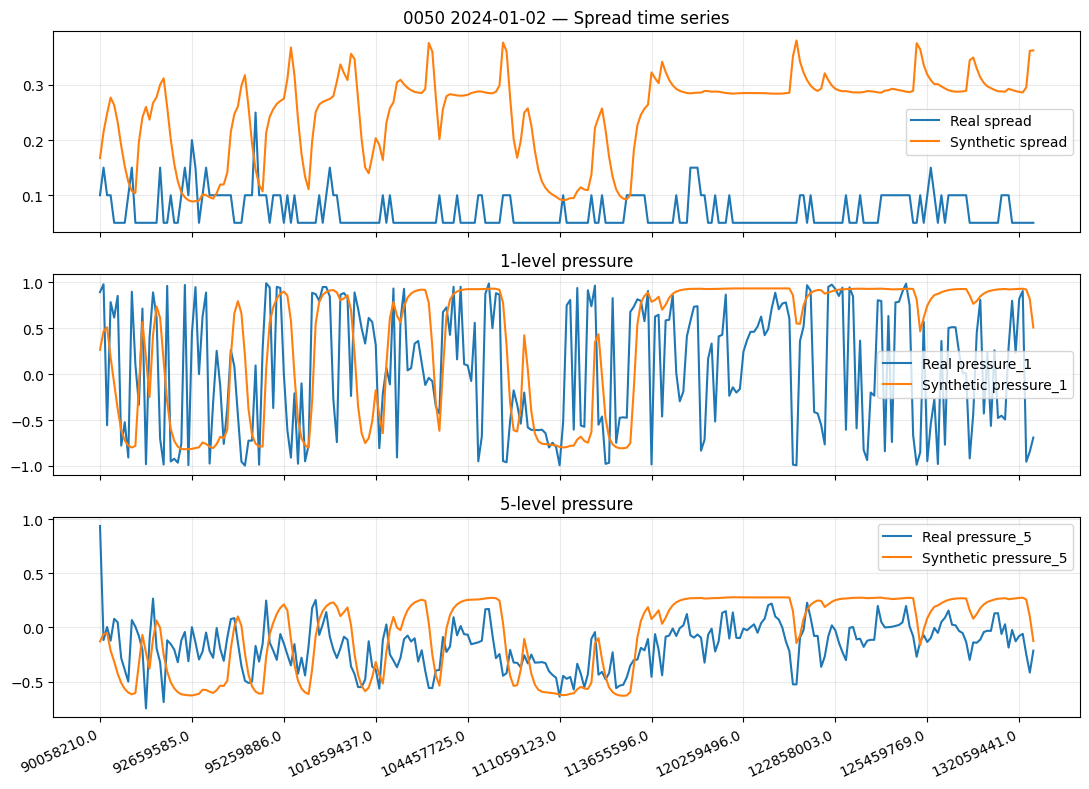

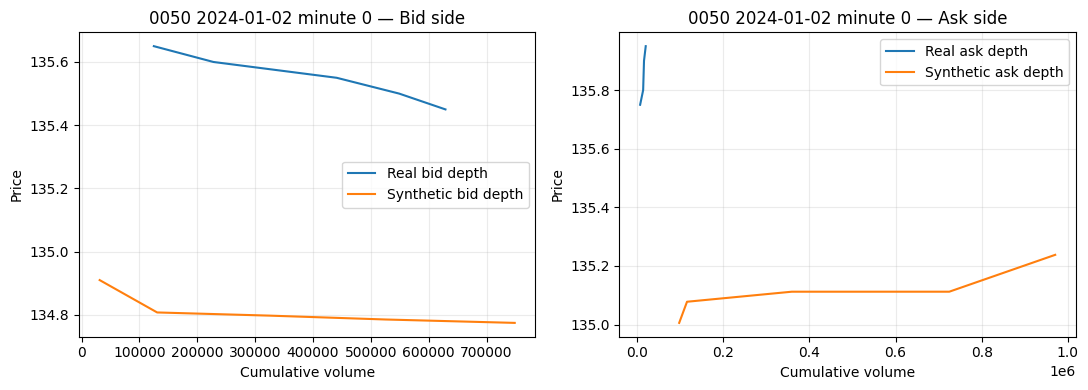

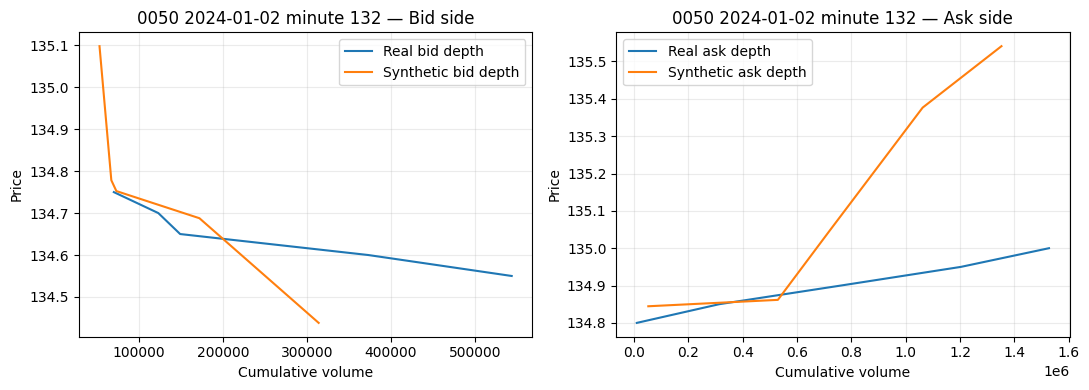

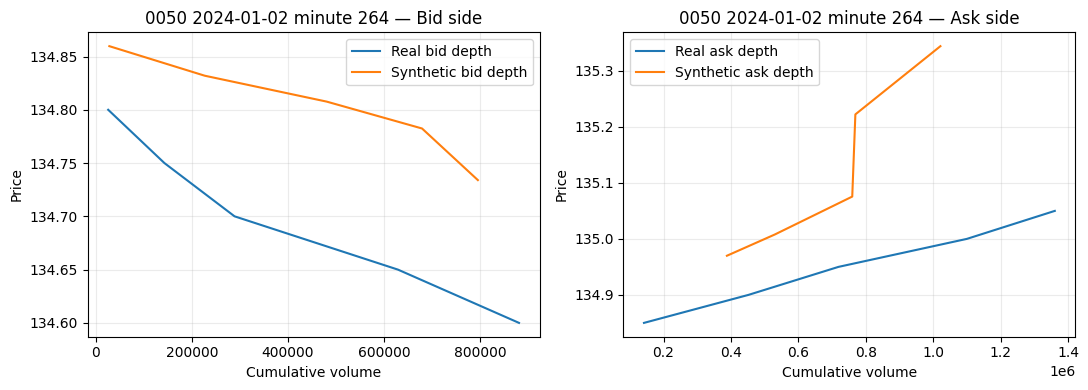

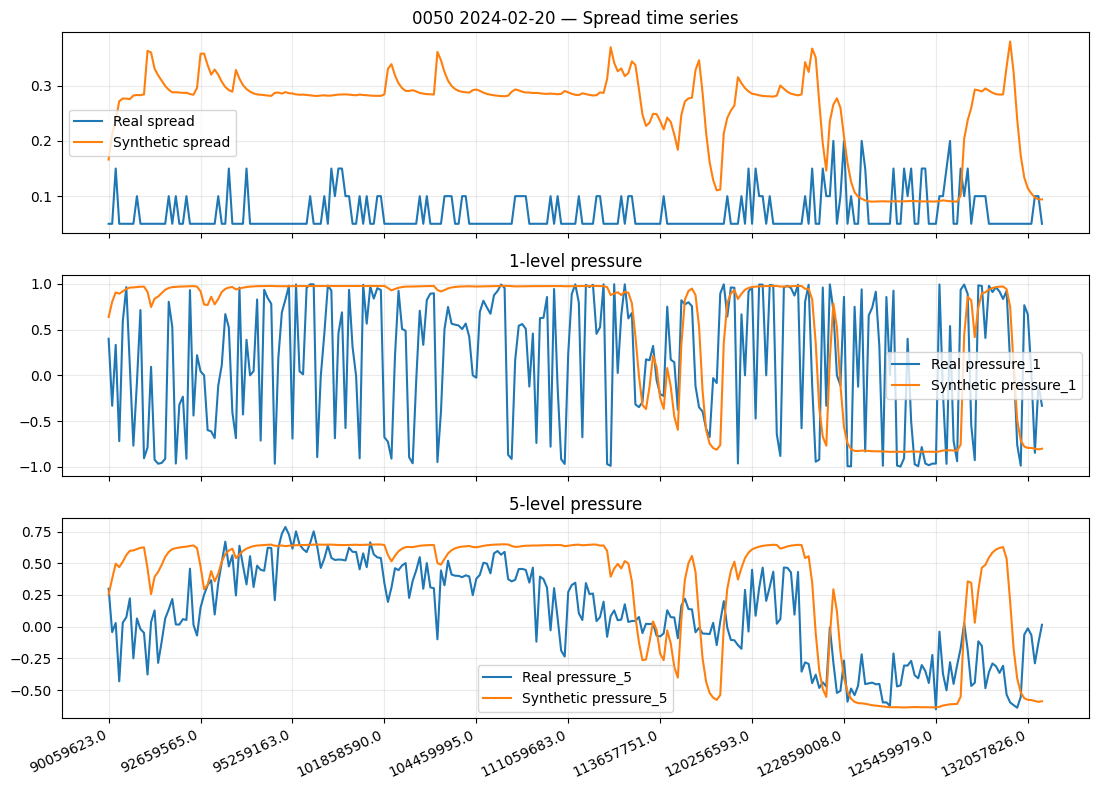

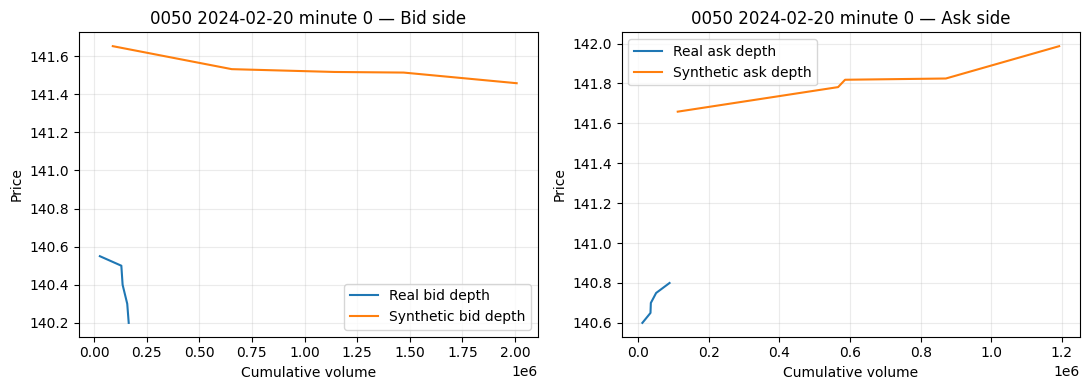

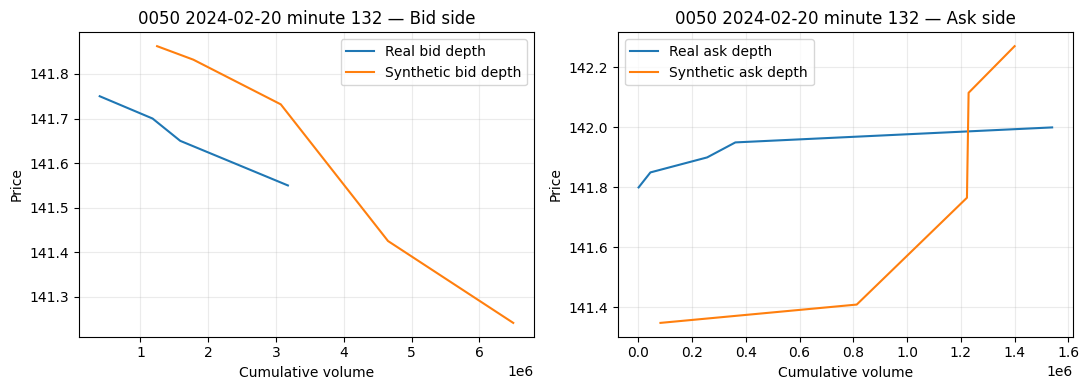

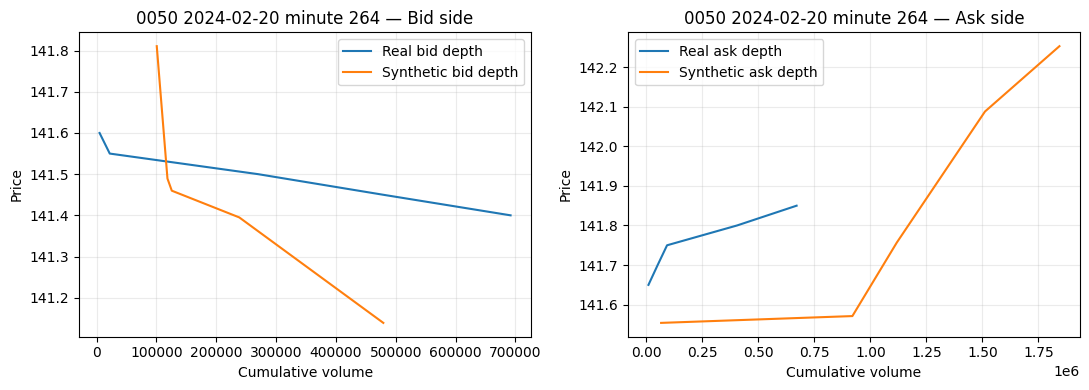

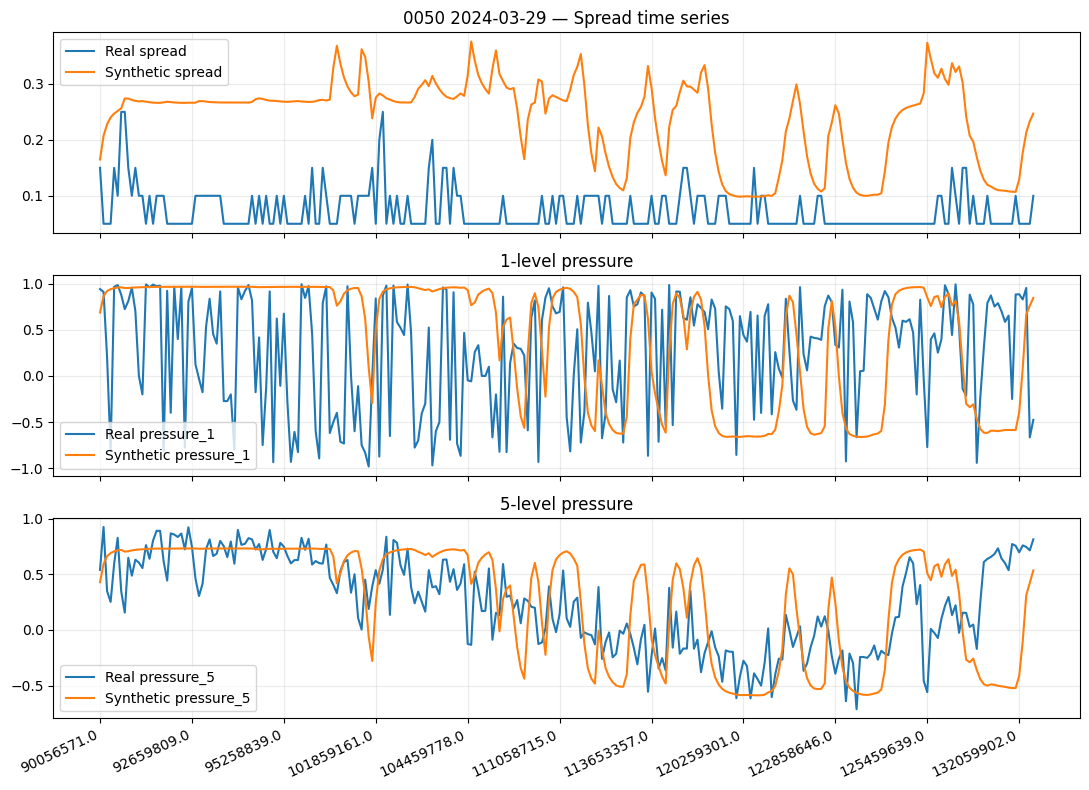

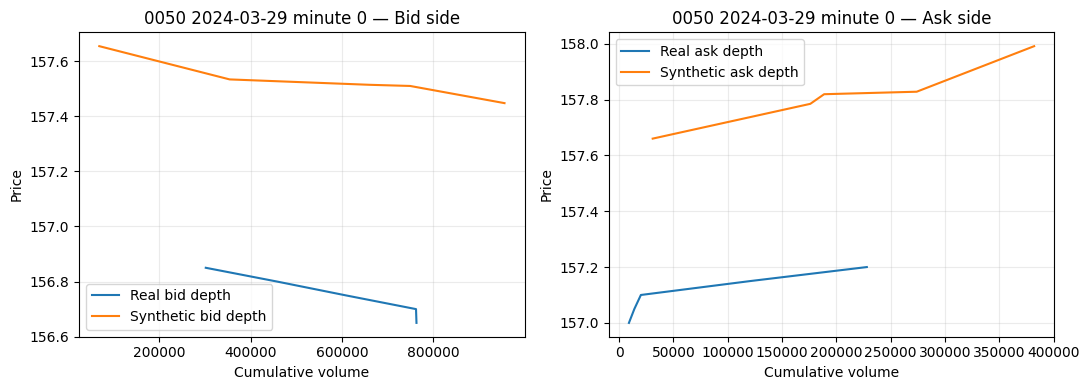

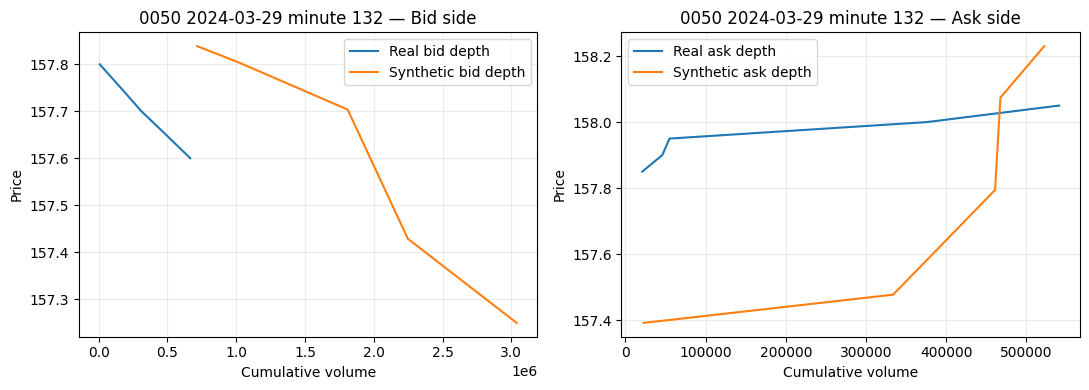

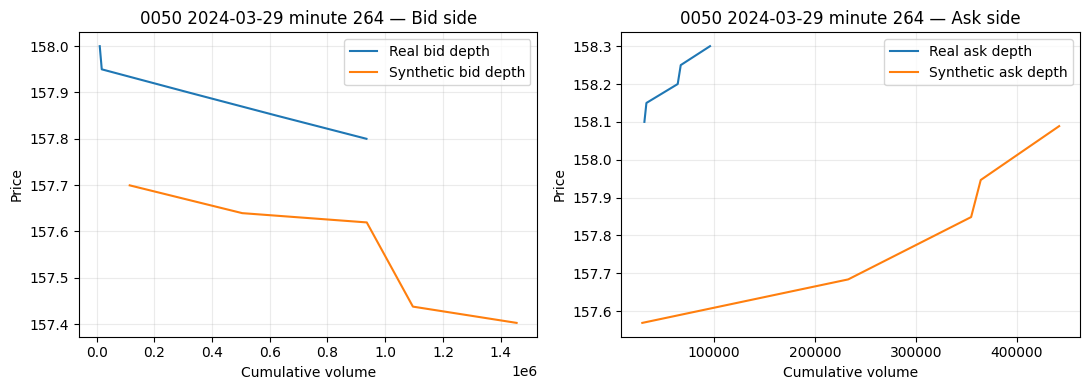


 0056 ...


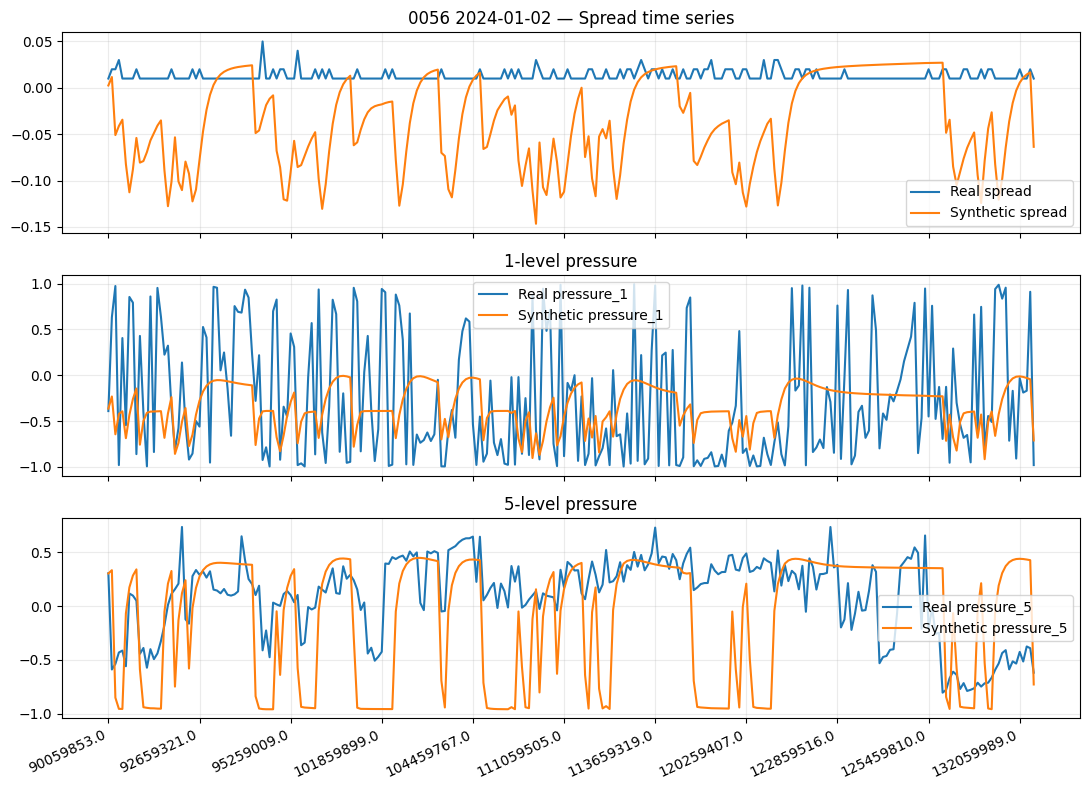

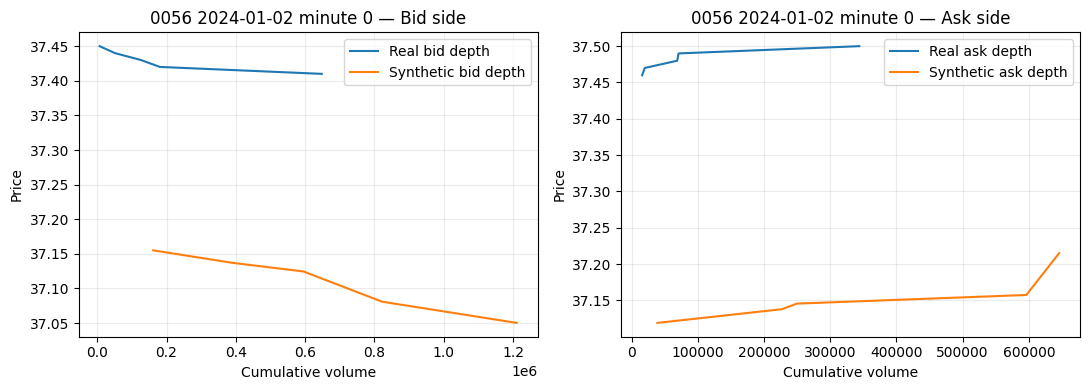

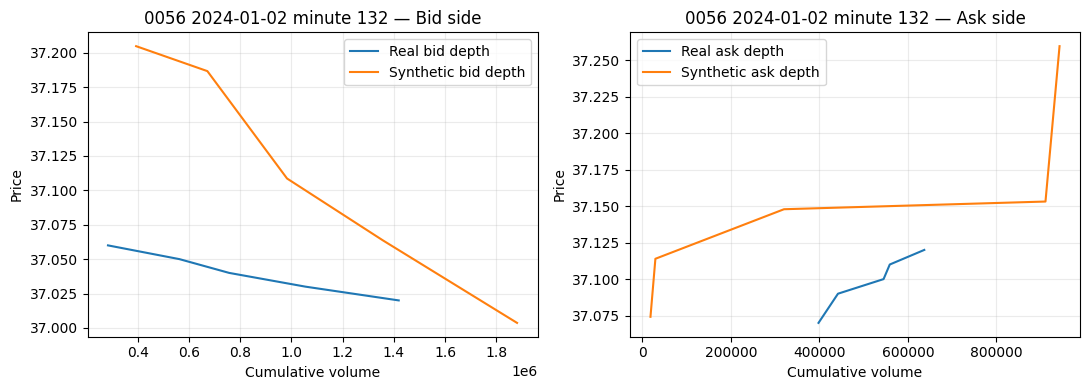

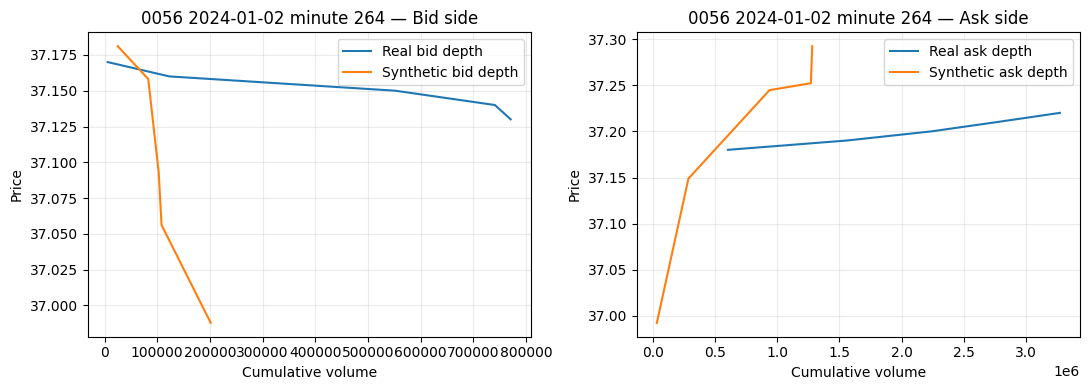

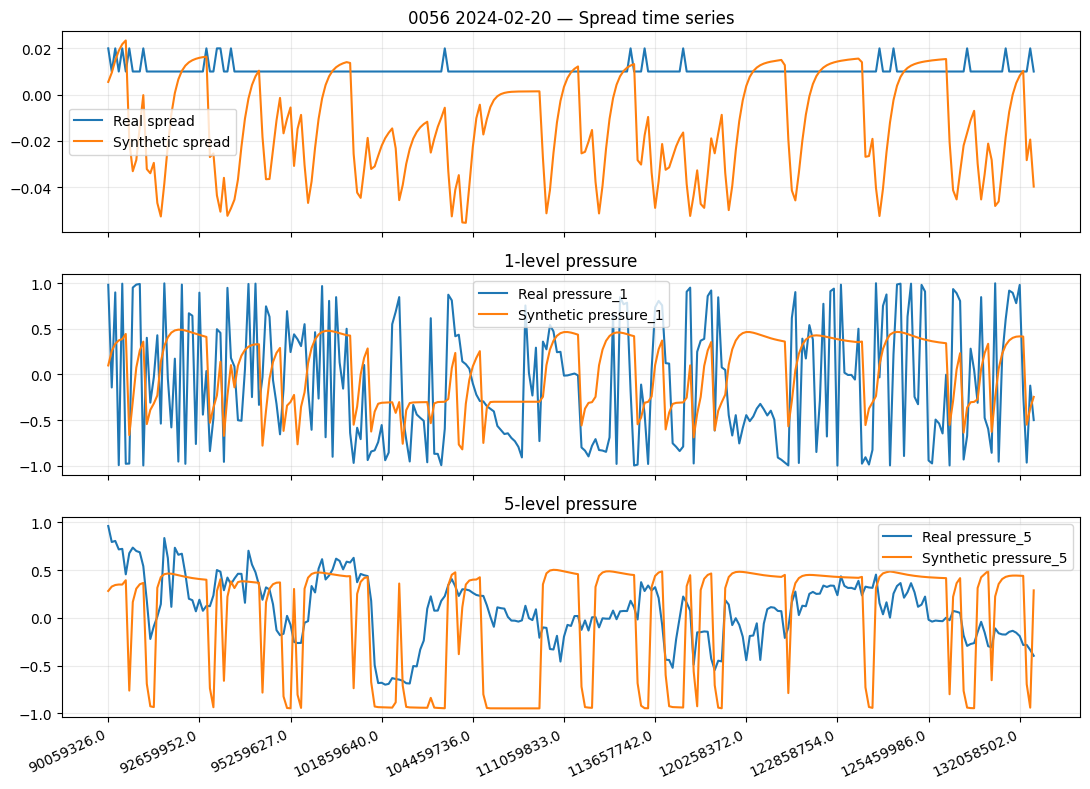

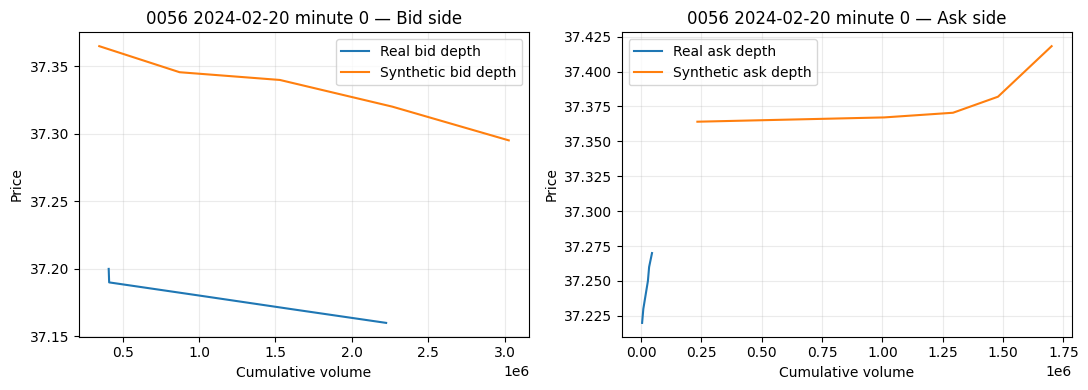

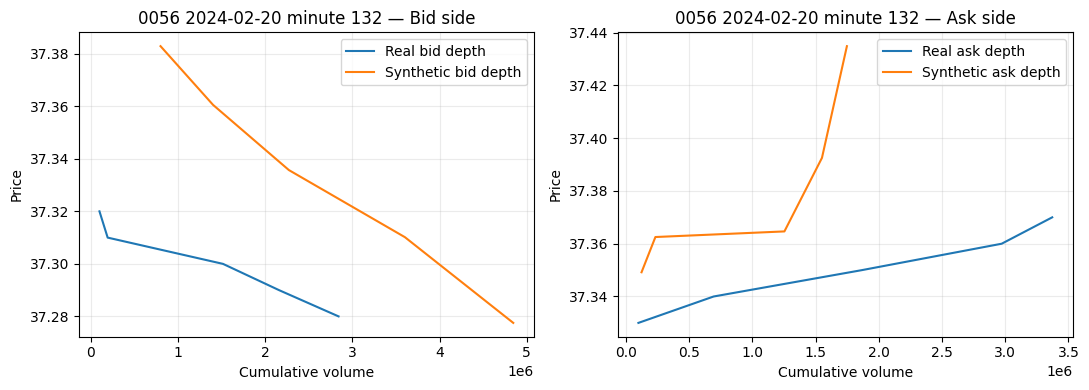

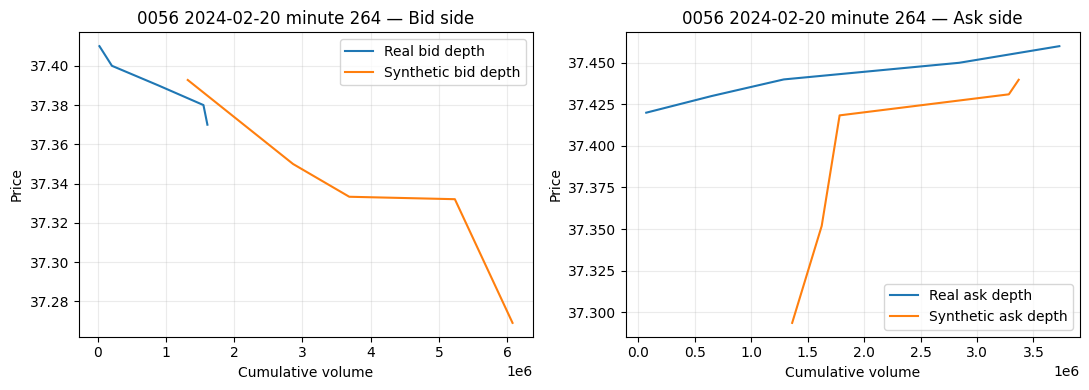

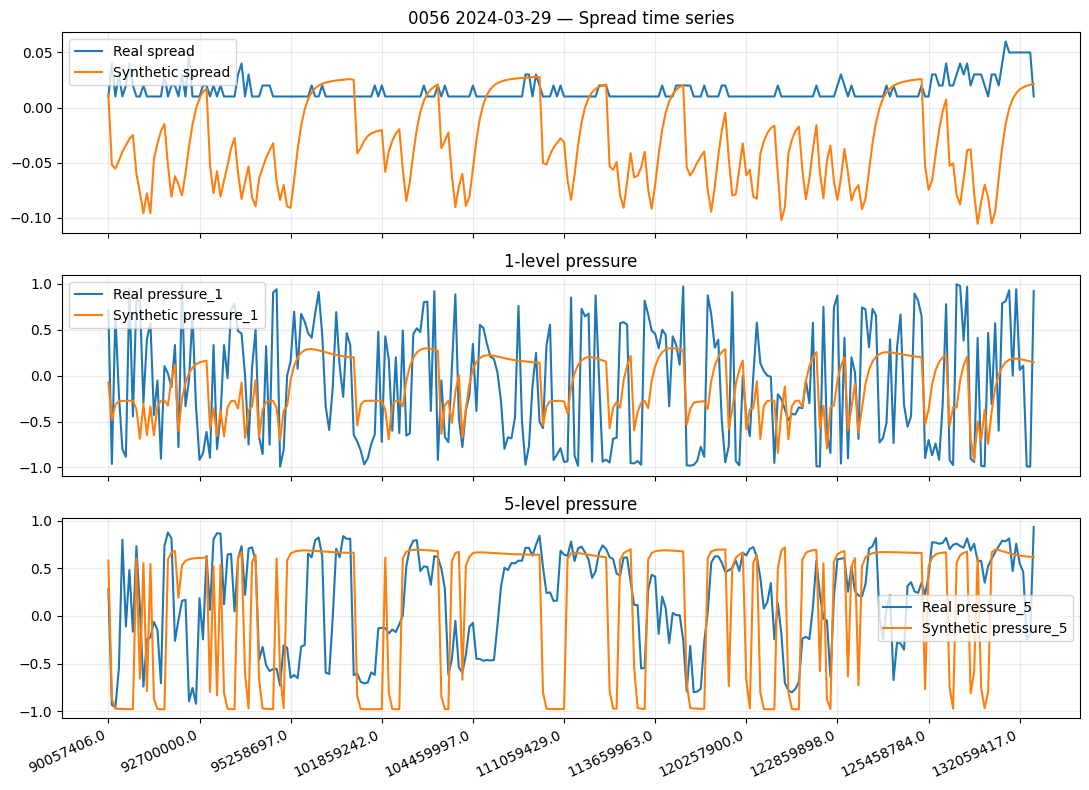

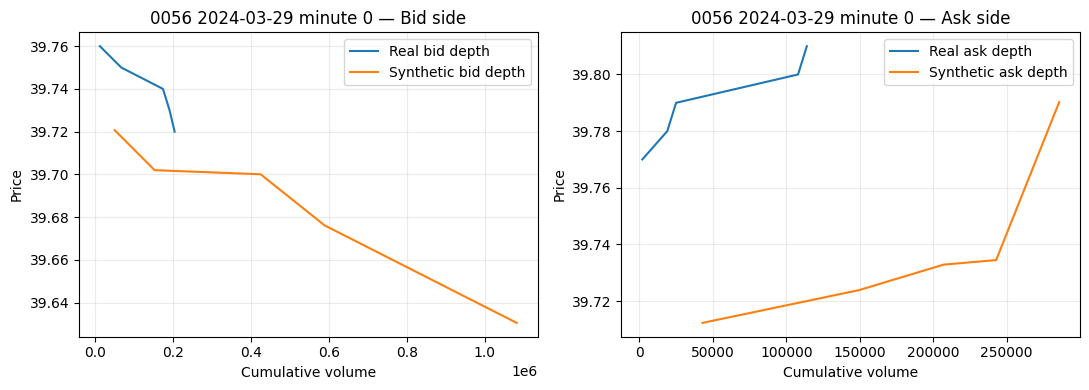

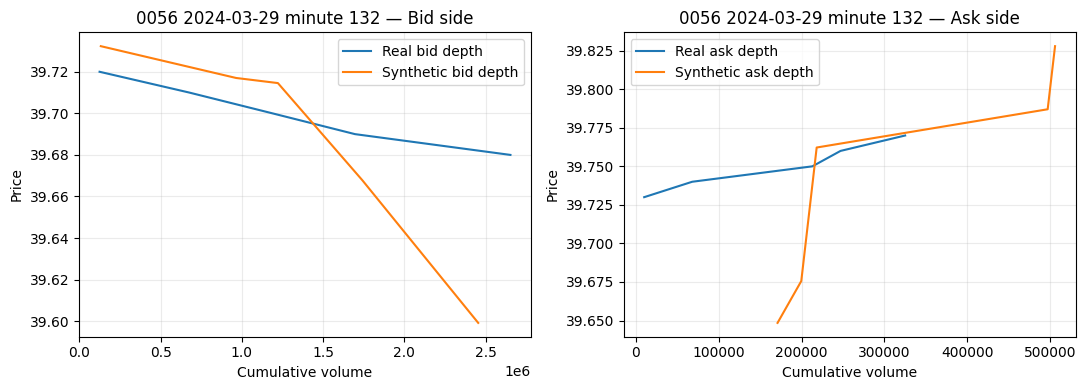

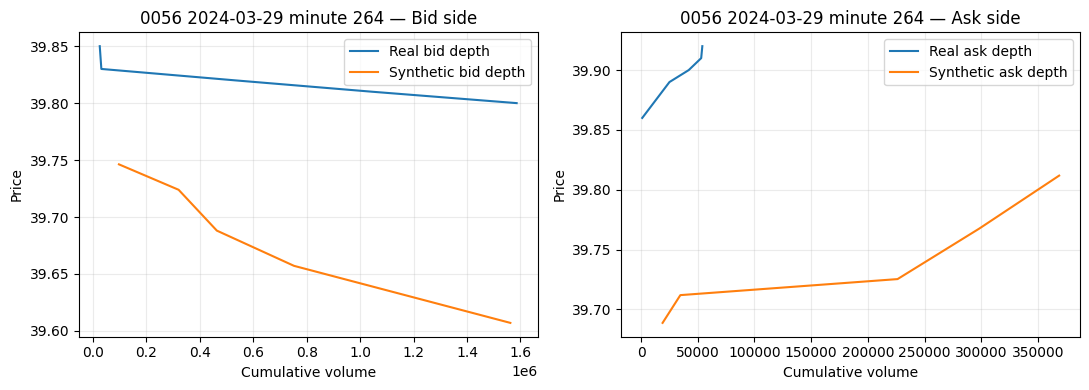


 2330 ...


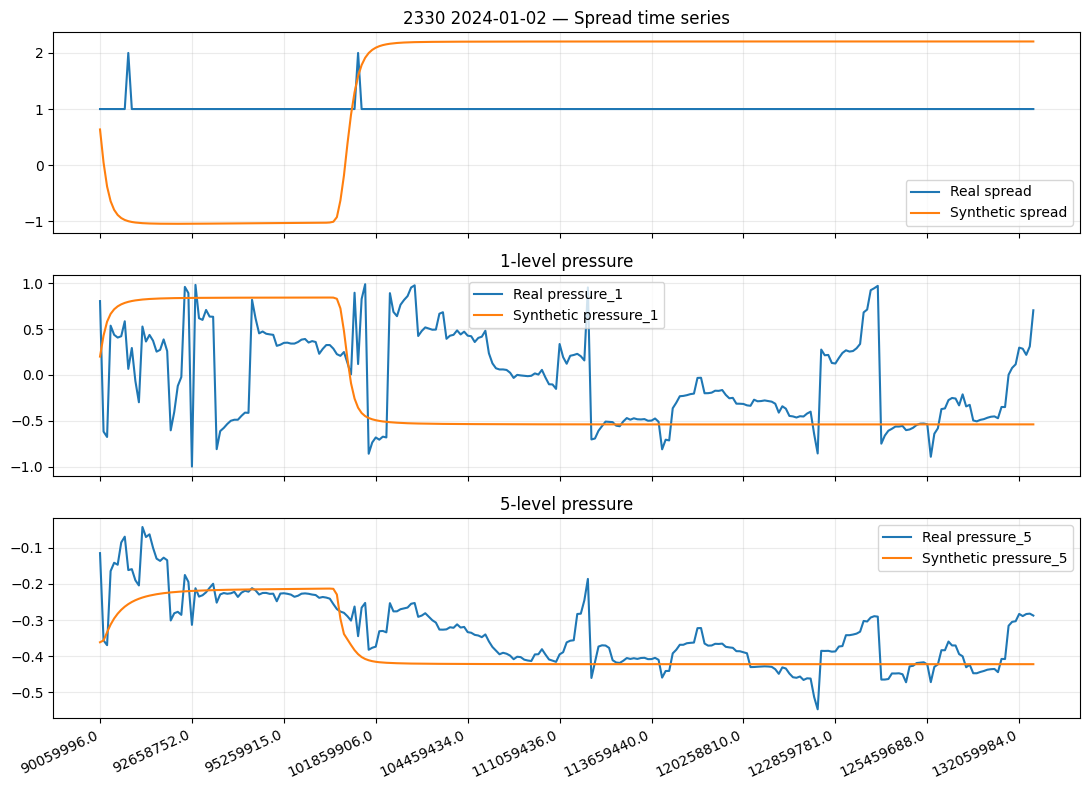

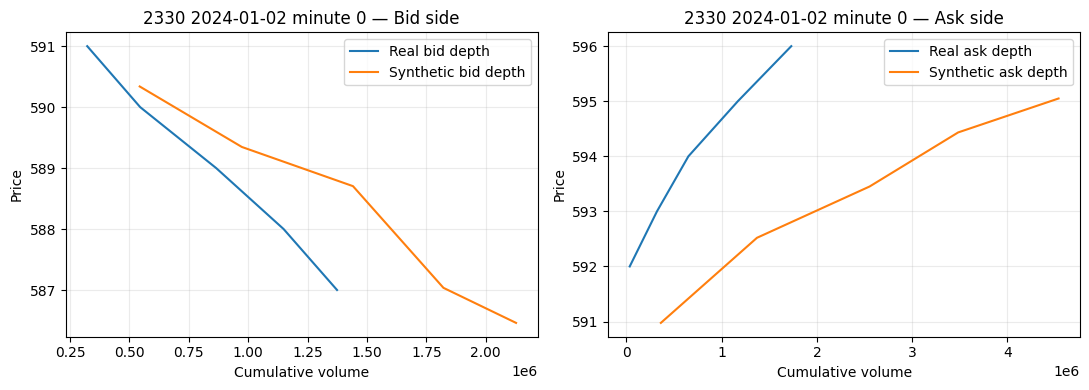

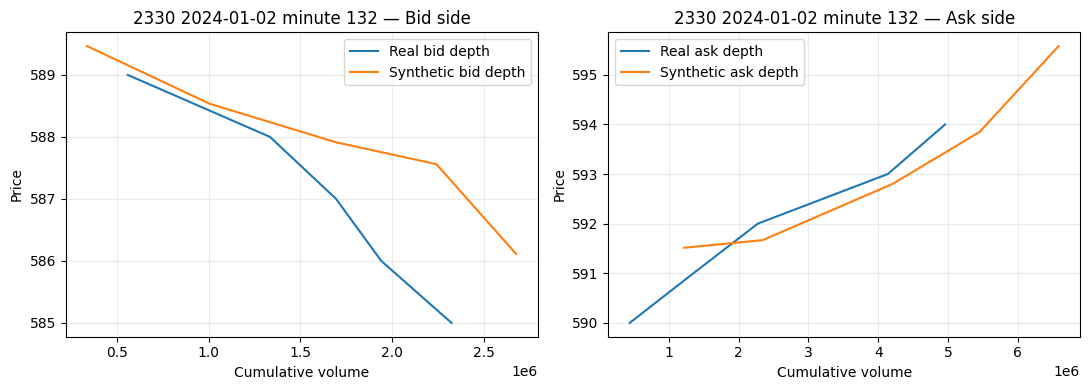

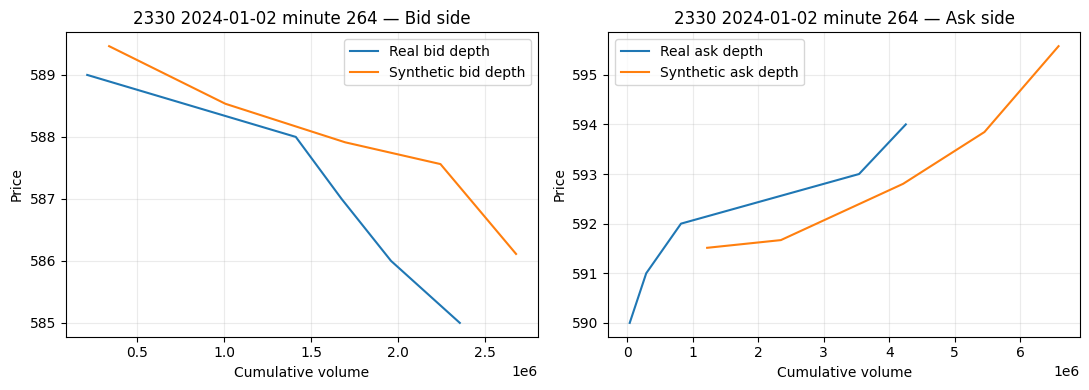

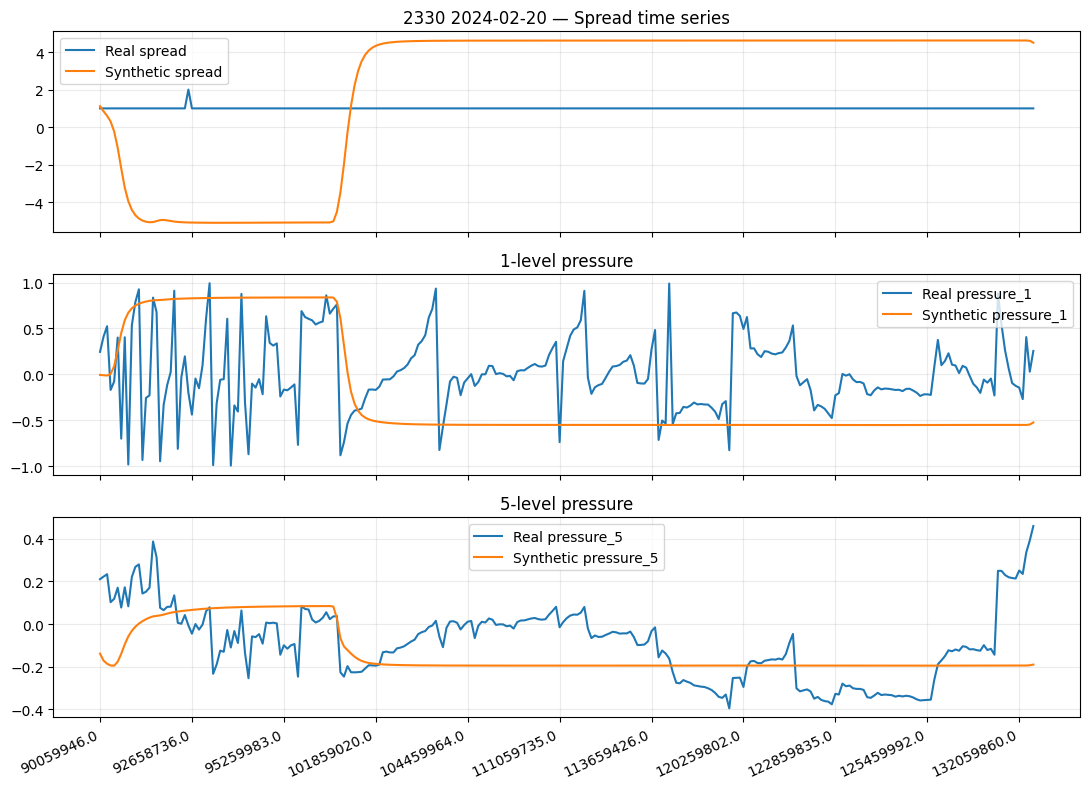

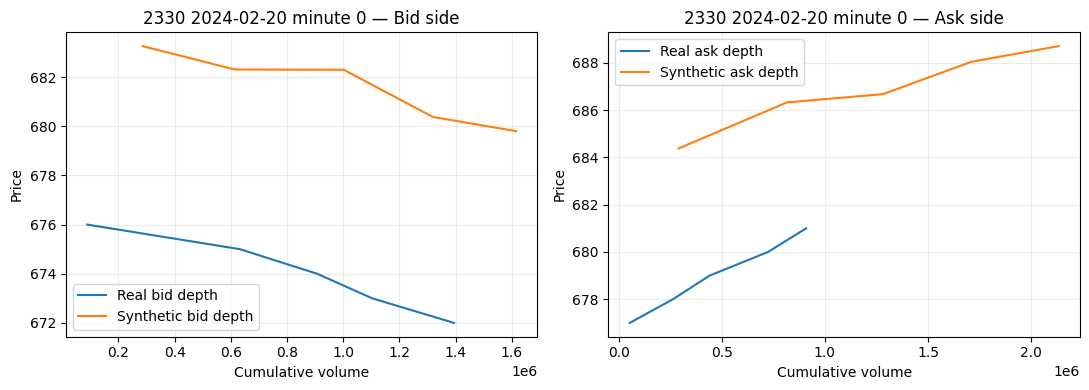

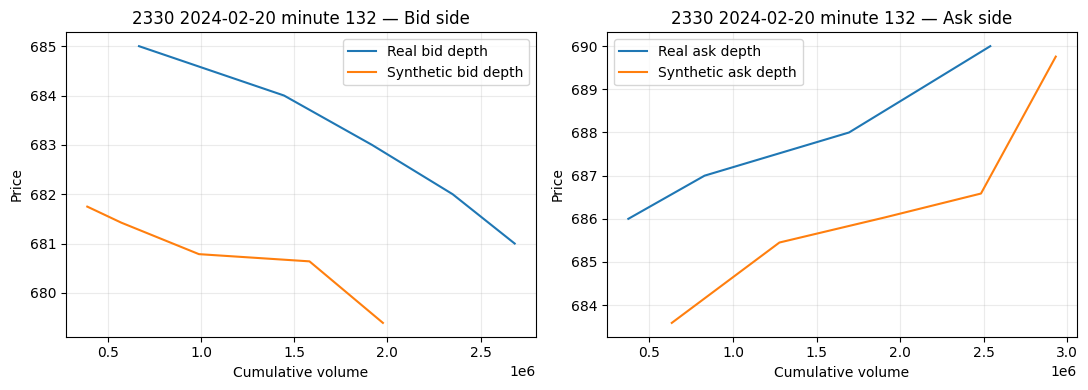

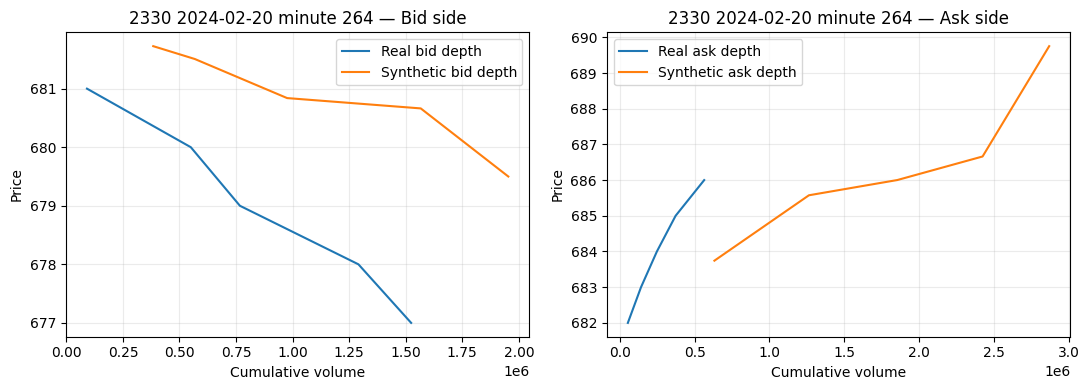

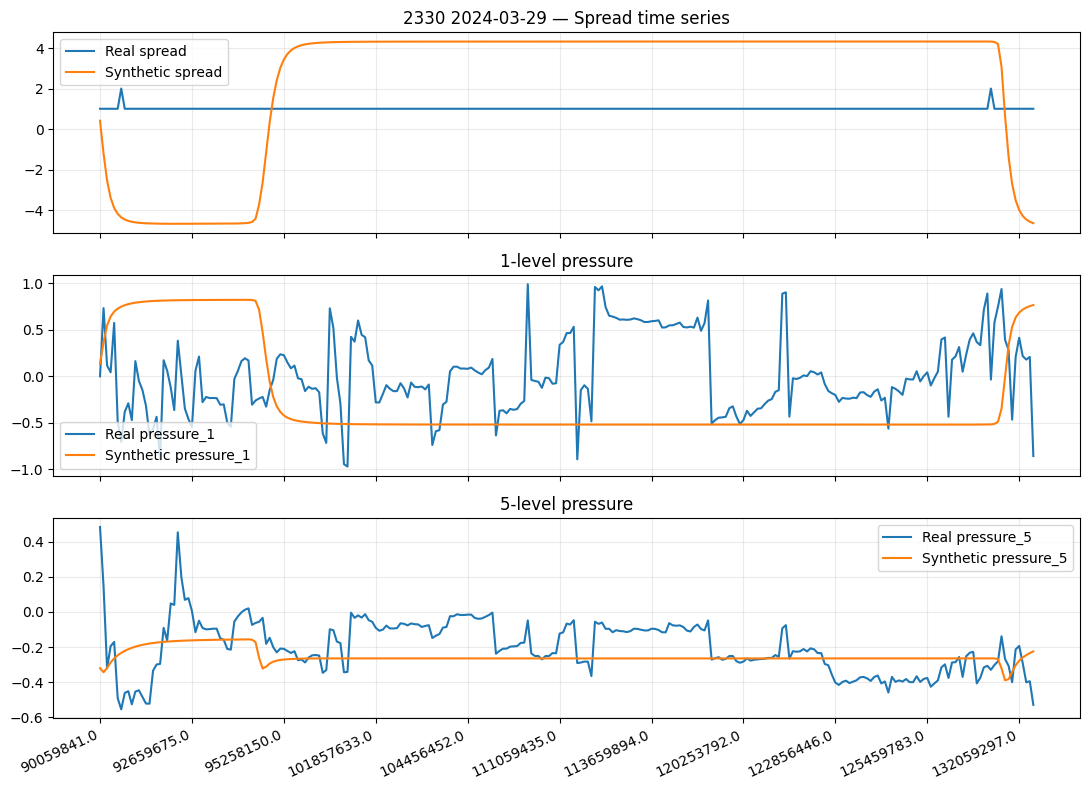

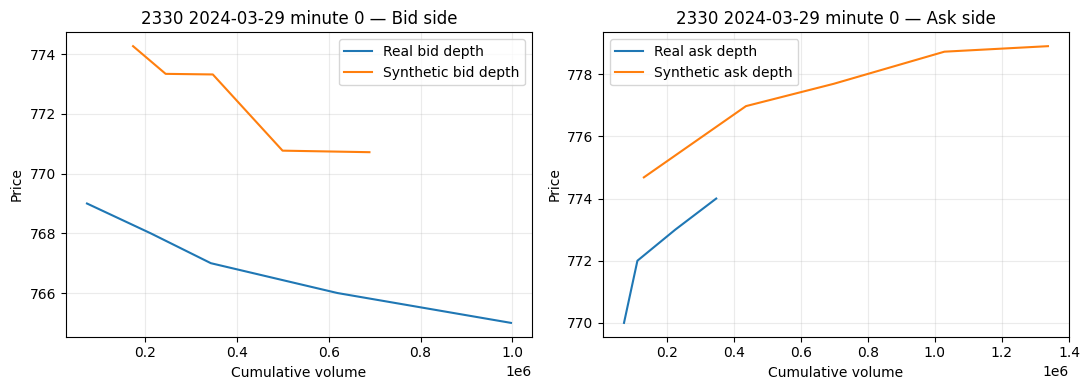

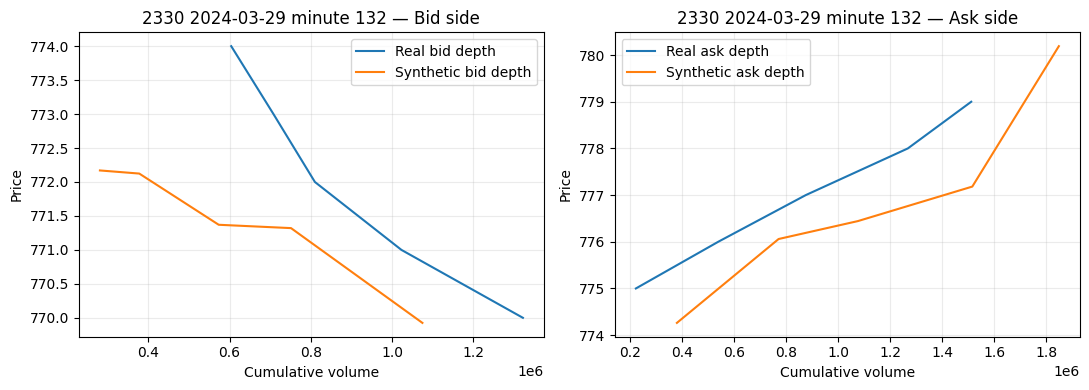

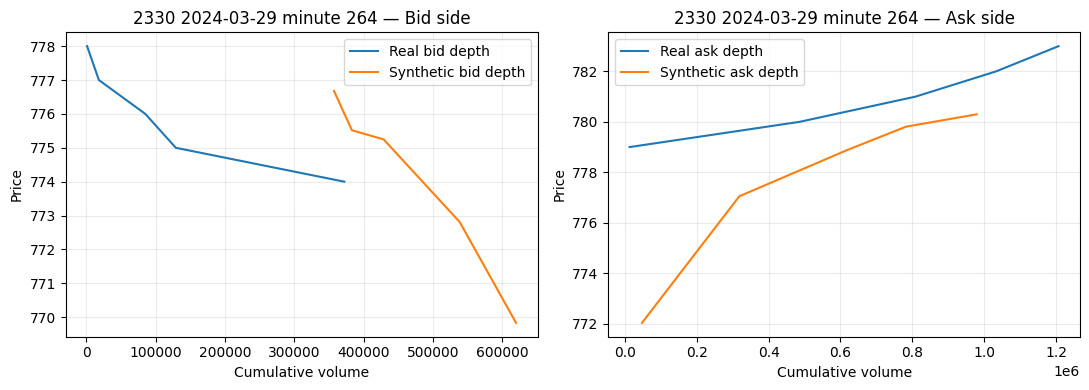

ticker        date  fraction_crossed_book  fraction_negative_vol_entries  \
0   0050  2024-01-02               0.000000                            0.0   
1   0050  2024-02-20               0.000000                            0.0   
2   0050  2024-03-29               0.000000                            0.0   
3   0056  2024-01-02               0.675472                            0.0   
4   0056  2024-02-20               0.637736                            0.0   
5   0056  2024-03-29               0.728302                            0.0   
6   2330  2024-01-02               0.256604                            0.0   
7   2330  2024-02-20               0.252830                            0.0   
8   2330  2024-03-29               0.207547                            0.0   

   fraction_ask_monotone  fraction_bid_monotone  
0               0.007547               0.000000  
1               0.000000               0.000000  
2               0.000000               0.000000  
3               0.000000               0.000000  
4               0.000000               0.000000  
5               0.000000               0.000000  
6               0.041509               0.747170  
7               0.011321               0.000000  
8               0.015094               0.011321

In [101]:
def q3_pick_day_indices(day_dates: list[str], how_many: int = 3) -> list[int]:
    """
    Picks a few representative days first, middle, and last
    """
    n = len(day_dates)
    if n == 0:
        return []
    if how_many <= 1 or n == 1:
        return [0]
    if how_many == 2:
        return [0, n - 1]
    picks = [0, n // 2, n - 1]
    picks = sorted(set(picks))
    return picks[:how_many]


q3_quality_rows = []

for ticker in q3_tickers:
    print(f"\n {ticker} ...")
    pack = q3_load_or_build_synthetic_days(ticker, q3_test_months)

    real_raw = pack["real_raw"]
    syn_raw = pack["synthetic_raw"]
    day_dates = pack["day_dates"]
    feature_cols = pack["feature_cols"]
    time_days = pack["time_days"]

    chosen_day_idxs = q3_pick_day_indices(day_dates, how_many=q3_days_per_ticker)

    for di in chosen_day_idxs:
        day_label = day_dates[di]
        real_day = real_raw[di]
        syn_day  = syn_raw[di]
        times = time_days[di]

        diag = q3_day_quality_diagnostics(feature_cols, syn_day)
        q3_quality_rows.append({"ticker": ticker, "date": day_label, **diag})

        # time-series
        ts_out = q3_output_root / ticker / f"{ticker}_{day_label}_timeseries.png"
        q3_plot_day_timeseries(
            ticker=ticker,
            day_label=day_label,
            time_labels=times,
            feature_cols=feature_cols,
            real_day=real_day,
            syn_day=syn_day,
            out_path=ts_out,
        )

        for minute_idx in q3_minutes_to_plot:
            snap_out = q3_output_root / ticker / f"{ticker}_{day_label}_snapshot_{minute_idx:03d}.png"
            q3_plot_snapshot_depth_comparison(
                ticker=ticker,
                day_label=day_label,
                minute_idx=minute_idx,
                feature_cols=feature_cols,
                real_day=real_day,
                syn_day=syn_day,
                out_path=snap_out,
            )

q3_quality_summary = pd.DataFrame(q3_quality_rows)
q3_quality_summary


In [102]:
q3_diag_csv = q3_output_root / "q3_synthetic_quality_diagnostics.csv"
q3_quality_summary.to_csv(q3_diag_csv, index=False)
